# Импортируем необходимые библиотеки


In [ ]:
!pip install arch
!pip install statsmodels

# DEBUG
!pip install -Uqq ipdb

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import pickle
import joblib
from sklearn.preprocessing import MinMaxScaler
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame

# DEBUG
import ipdb

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

# Загрузим датасет


In [ ]:
df_initial = pd.read_csv('data_full.csv', parse_dates=[0])
df_initial = df_initial.drop(columns=['Medics per 10k', 'Oftalmologi per 10k', 'Alcohol use'])
df_initial

,Year,Total population,City population,Village population,Support,Education,Health,Social,Real money,Low money,...,Against economy,Victims prop,Internet used for federal services prop,Internet used for MFC prop,Got result prop,Internet used total prop,15-72 prop,VRP,"Consumption, rub","VRP index, %"
0,2016-01-01,4236.0,2872.1,1363.9,10.1,23.4,27.7,17.0,96.7,14.2,...,2960.0,2.6,42.2,35.7,56.6,78.1,82.7,324802.1,313200.7,103.3
1,2017-01-01,4231.3,2874.0,1357.3,11.4,24.1,21.0,21.9,100.6,13.9,...,2265.0,2.9,48.7,34.8,66.1,80.0,85.0,341163.4,328334.0,102.7
2,2018-01-01,4220.4,2871.4,1349.0,9.7,27.4,26.0,23.7,102.3,13.2,...,2178.0,2.9,60.1,30.7,78.4,82.3,88.3,367627.9,349235.6,102.5
3,2019-01-01,4202.3,2863.7,1338.6,9.6,24.5,24.2,20.6,101.2,13.3,...,2064.0,3.1,59.3,28.5,80.4,83.3,89.4,389521.4,361083.1,102.1
4,2020-01-01,4197.8,2862.9,1334.9,10.1,22.5,26.0,23.1,98.6,13.0,...,1866.0,3.0,60.9,25.3,86.3,87.6,90.9,409240.7,368512.4,97.8
5,2021-01-01,4181.5,2850.8,1330.7,9.3,21.8,26.0,22.1,103.5,12.0,...,3396.0,3.0,72.2,24.2,90.9,88.0,91.1,483970.4,427258.2,106.8
6,2022-01-01,4192.3,2845.4,1346.9,10.1,22.3,22.3,23.3,100.7,10.5,...,3509.0,3.0,76.3,22.3,93.9,91.4,94.5,483970.4,427258.2,106.8


In [ ]:
# Переиеменуем Year на Date
df_initial = df_initial.rename(columns={'Year': 'Date'})

In [ ]:
# Установим Date в качестве индекса и посмотрим что получилось
df_initial = df_initial.set_index('Date')
df_initial

,Total population,City population,Village population,Support,Education,Health,Social,Real money,Low money,Mean money,...,Against economy,Victims prop,Internet used for federal services prop,Internet used for MFC prop,Got result prop,Internet used total prop,15-72 prop,VRP,"Consumption, rub","VRP index, %"
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,4236.0,2872.1,1363.9,10.1,23.4,27.7,17.0,96.7,14.2,26655.4,...,2960.0,2.6,42.2,35.7,56.6,78.1,82.7,324802.1,313200.7,103.3
2017-01-01,4231.3,2874.0,1357.3,11.4,24.1,21.0,21.9,100.6,13.9,27741.4,...,2265.0,2.9,48.7,34.8,66.1,80.0,85.0,341163.4,328334.0,102.7
2018-01-01,4220.4,2871.4,1349.0,9.7,27.4,26.0,23.7,102.3,13.2,29097.1,...,2178.0,2.9,60.1,30.7,78.4,82.3,88.3,367627.9,349235.6,102.5
2019-01-01,4202.3,2863.7,1338.6,9.6,24.5,24.2,20.6,101.2,13.3,30865.8,...,2064.0,3.1,59.3,28.5,80.4,83.3,89.4,389521.4,361083.1,102.1
2020-01-01,4197.8,2862.9,1334.9,10.1,22.5,26.0,23.1,98.6,13.0,31519.4,...,1866.0,3.0,60.9,25.3,86.3,87.6,90.9,409240.7,368512.4,97.8
2021-01-01,4181.5,2850.8,1330.7,9.3,21.8,26.0,22.1,103.5,12.0,35049.7,...,3396.0,3.0,72.2,24.2,90.9,88.0,91.1,483970.4,427258.2,106.8
2022-01-01,4192.3,2845.4,1346.9,10.1,22.3,22.3,23.3,100.7,10.5,40008.0,...,3509.0,3.0,76.3,22.3,93.9,91.4,94.5,483970.4,427258.2,106.8


In [ ]:
# Получим список названий всех колонок кроме колонки Date
labels = df_initial.columns.tolist()
labels

['Total population',
 'City population',
 'Village population',
 'Support',
 'Education',
 'Health',
 'Social',
 'Real money',
 'Low money',
 'Mean money',
 'Money tempo',
 'Pension',
 'Total min',
 'Workers min',
 'Pensioners min',
 'Children min',
 'No food',
 'Animal',
 'Prod',
 'Meat',
 'Milk',
 'Egg',
 'Potato',
 'Vegetable',
 'Fruit',
 'Self crop',
 'Self meat',
 'Self milk',
 'Self egg',
 'Buy meat',
 'Buy milk',
 'Buy egg',
 'Buy potato',
 'Buy vegetable',
 'Buy fruit',
 'Harvest crop',
 'Harvest sunflower',
 'Harvest potato',
 'Harvest vegetable',
 'Harvest berry',
 'Harvest grape',
 'Cattle',
 'Pig',
 'Sheep',
 'Bird',
 'Prod meat',
 'Prod milk',
 'Prod egg',
 'Annual Medical Examination',
 'Regular PE',
 'Predicted Healthy Life Duration',
 'Predicted Life Duration',
 'Healthy Lifestyle Prop',
 'Medicless Localities',
 'Available Medical Help',
 'Meds per 10k',
 'Terapevts per 10k',
 'Hirurgs per 10k',
 'Ginekologi per 10k',
 'Pediatri per 10k',
 'Lors per 10k',
 'Nervrologi 

In [ ]:
# Функция MinMax нормализации
def normalize(df: DataFrame) -> (DataFrame, MinMaxScaler):
  scaler = MinMaxScaler()
  df_normalized = df.copy()
  numeric_columns = df.select_dtypes(include=['number']).columns
  df_normalized[numeric_columns] = scaler.fit_transform(df[numeric_columns])
  return (df_normalized, scaler)

In [ ]:
# Нормализуем все значения при помощи MinMaxScaler
df, scaler = normalize(df_initial)

In [ ]:
# Сохраним скейлер в файл чтобы дальше его мог использовать сервис
joblib.dump(scaler, "models/scaler.pkl")

['models/scaler.pkl']

In [ ]:
# Посмотрим на измененный датафрейм
df

,Total population,City population,Village population,Support,Education,Health,Social,Real money,Low money,Mean money,...,Against economy,Victims prop,Internet used for federal services prop,Internet used for MFC prop,Got result prop,Internet used total prop,15-72 prop,VRP,"Consumption, rub","VRP index, %"
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1.000000,0.933566,1.000000,0.380952,0.285714,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.665855,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.611111
2017-01-01,0.913761,1.000000,0.801205,1.000000,0.410714,0.000000,0.731343,0.573529,0.918919,0.081332,...,0.242848,0.6,0.190616,0.932836,0.254692,0.142857,0.194915,0.102792,0.132681,0.544444
2018-01-01,0.713761,0.909091,0.551205,0.190476,1.000000,0.746269,1.000000,0.823529,0.729730,0.182863,...,0.189897,0.6,0.524927,0.626866,0.584450,0.315789,0.474576,0.269060,0.315936,0.522222
2019-01-01,0.381651,0.639860,0.237952,0.142857,0.482143,0.477612,0.537313,0.661765,0.756757,0.315324,...,0.120511,1.0,0.501466,0.462687,0.638070,0.390977,0.567797,0.406609,0.419809,0.477778
2020-01-01,0.299083,0.611888,0.126506,0.380952,0.125000,0.746269,0.910448,0.279412,0.675676,0.364274,...,0.000000,0.8,0.548387,0.223881,0.796247,0.714286,0.694915,0.530499,0.484946,0.000000
2021-01-01,0.000000,0.188811,0.000000,0.000000,0.000000,0.746269,0.761194,1.000000,0.405405,0.628664,...,0.931223,0.8,0.879765,0.141791,0.919571,0.744361,0.711864,1.000000,1.000000,1.000000
2022-01-01,0.198165,0.000000,0.487952,0.380952,0.089286,0.194030,0.940299,0.588235,0.000000,1.000000,...,1.000000,0.8,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Убедимся что изначальный датафрейм не поврежден
df_initial

,Total population,City population,Village population,Support,Education,Health,Social,Real money,Low money,Mean money,...,Against economy,Victims prop,Internet used for federal services prop,Internet used for MFC prop,Got result prop,Internet used total prop,15-72 prop,VRP,"Consumption, rub","VRP index, %"
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,4236.0,2872.1,1363.9,10.1,23.4,27.7,17.0,96.7,14.2,26655.4,...,2960.0,2.6,42.2,35.7,56.6,78.1,82.7,324802.1,313200.7,103.3
2017-01-01,4231.3,2874.0,1357.3,11.4,24.1,21.0,21.9,100.6,13.9,27741.4,...,2265.0,2.9,48.7,34.8,66.1,80.0,85.0,341163.4,328334.0,102.7
2018-01-01,4220.4,2871.4,1349.0,9.7,27.4,26.0,23.7,102.3,13.2,29097.1,...,2178.0,2.9,60.1,30.7,78.4,82.3,88.3,367627.9,349235.6,102.5
2019-01-01,4202.3,2863.7,1338.6,9.6,24.5,24.2,20.6,101.2,13.3,30865.8,...,2064.0,3.1,59.3,28.5,80.4,83.3,89.4,389521.4,361083.1,102.1
2020-01-01,4197.8,2862.9,1334.9,10.1,22.5,26.0,23.1,98.6,13.0,31519.4,...,1866.0,3.0,60.9,25.3,86.3,87.6,90.9,409240.7,368512.4,97.8
2021-01-01,4181.5,2850.8,1330.7,9.3,21.8,26.0,22.1,103.5,12.0,35049.7,...,3396.0,3.0,72.2,24.2,90.9,88.0,91.1,483970.4,427258.2,106.8
2022-01-01,4192.3,2845.4,1346.9,10.1,22.3,22.3,23.3,100.7,10.5,40008.0,...,3509.0,3.0,76.3,22.3,93.9,91.4,94.5,483970.4,427258.2,106.8


In [ ]:
# Создадим список интересующих нас признаков для тестов
targets = ['Total population', 'City population', 'Village population']
df[targets]

,Total population,City population,Village population
Date,,,
2016-01-01,1.000000,0.933566,1.000000
2017-01-01,0.913761,1.000000,0.801205
2018-01-01,0.713761,0.909091,0.551205
2019-01-01,0.381651,0.639860,0.237952
2020-01-01,0.299083,0.611888,0.126506
2021-01-01,0.000000,0.188811,0.000000
2022-01-01,0.198165,0.000000,0.487952


In [ ]:
# Разделим данные на обучение и тесты
start = dt.datetime(2016,1,1)
split_date = dt.datetime(2022,1,1)
end = dt.datetime(2022,1,1)
next = dt.datetime(2023,1,1)

In [ ]:
# Объявим пустые словари полученных значений для наших моделей
forecasted_values = {
    'arima': {},
    'arch': {},
    'garch': {}
}

In [ ]:
# Нам потребуются полученные модели для работы сервиса
trained_models = {
    'arima': {},
    'arch': {},
    'garch': {}
}

### Обучим каждую модель для каждого признака и посмотрим результат

In [ ]:
# ARIMA
for column in labels:
  model = ARIMA(df[column], order=[5, 1, 0])
  model.initialize_approximate_diffuse()
  result = model.fit()
  forecast = result.forecast(steps=10)
  forecasted_value = forecast.values.tolist()
  forecasted_values['arima'][column] = forecasted_value
  trained_models['arima'][column] = result

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-

In [ ]:
# ARCH
for column in labels:
  model = arch_model(df[column], vol='ARCH', mean='AR', dist='t')
  result = model.fit(last_obs=split_date)
  forecasts = result.forecast(horizon=3, start=split_date)
  forecasted_value = forecast.values.tolist()
  forecasted_values['arch'][column] = forecasted_value
  trained_models['arch'][column] = result

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6.306807302457123
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2.5575586129646535
Iteration:      3,   Func. Count:     20,   Neg. LLF: 2.4361079539540746
Iteration:      4,   Func. Count:     25,   Neg. LLF: 2.430789112804314
Iteration:      5,   Func. Count:     30,   Neg. LLF: 2.4263443473838366
Iteration:      6,   Func. Count:     35,   Neg. LLF: 2.4034123665690847
Iteration:      7,   Func. Count:     40,   Neg. LLF: 2.402907626346752
Iteration:      8,   Func. Count:     45,   Neg. LLF: 2.4025370708838816
Iteration:      9,   Func. Count:     50,   Neg. LLF: 2.401385614026866
Iteration:     10,   Func. Count:     55,   Neg. LLF: 2.3988345784334477
Iteration:     11,   Func. Count:     60,   Neg. LLF: 2.3928452055397704
Iteration:     12,   Func. Count:     65,   Neg. LLF: 2.3802160842870013
Iteration:     13,   Func. Count:     70,   Neg. LLF: 2.354078684052063
Iteration:     14,   Func. Count:     75,   Neg. LLF: 2.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07664. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     22,   Func. Count:    126,   Neg. LLF: 0.8100347819018008
Iteration:     23,   Func. Count:    131,   Neg. LLF: 0.8099703515144294
Iteration:     24,   Func. Count:    136,   Neg. LLF: 0.8099663797358317
Iteration:     25,   Func. Count:    141,   Neg. LLF: 0.8101216994074416
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.8099663796327117
            Iterations: 25
            Function evaluations: 151
            Gradient evaluations: 25
Iteration:      1,   Func. Count:      6,   Neg. LLF: 11.12612427158196
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4.268088554159732
Iteration:      3,   Func. Count:     21,   Neg. LLF: 2.495000062655304
Iteration:      4,   Func. Count:     26,   Neg. LLF: 2.4916886115385113
Iteration:      5,   Func. Count:     31,   Neg. LLF: 2.4858091507143634
Iteration:      6,   Func. Count:     36,   Neg. LLF: 2.48432215780091
Iteration:      7,   Func. Count:     41,   Neg. LLF: 2.48327557

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09948. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 19.646539223279184
Iteration:      2,   Func. Count:     14,   Neg. LLF: 348.2333554999608
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1.8077936034942423
Iteration:      4,   Func. Count:     25,   Neg. LLF: 1.8077395532917102
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1.8076871756434172
Iteration:      6,   Func. Count:     35,   Neg. LLF: 1.8076686573403589
Iteration:      7,   Func. Count:     40,   Neg. LLF: 1.807655399391787
Iteration:      8,   Func. Count:     45,   Neg. LLF: 1.8076348252601568
Iteration:      9,   Func. Count:     50,   Neg. LLF: 1.8075767932702482
Iteration:     10,   Func. Count:     55,   Neg. LLF: 1.8074258307739217
Iteration:     11,   Func. Count:     60,   Neg. LLF: 1.8069804514093113
Iteration:     12,   Func. Count:     65,   Neg. LLF: 1.8050579481003353
Iteration:     13,   Func. Count:     70,   Neg. LLF: 5.471467166115429
Iteration:     14,   Func. Count:     76,   Neg. LLF: 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03595. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04255. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 9.803828285872573
Iteration:      2,   Func. Count:     14,   Neg. LLF: 18.770707004963075
Iteration:      3,   Func. Count:     22,   Neg. LLF: -1.3949525926986326
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1.3950254383904601
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1.3950714934171438
Iteration:      6,   Func. Count:     37,   Neg. LLF: -1.3952964279985298
Iteration:      7,   Func. Count:     42,   Neg. LLF: -1.3957537371649513
Iteration:      8,   Func. Count:     47,   Neg. LLF: -1.3969637518099631
Iteration:      9,   Func. Count:     52,   Neg. LLF: -1.3997072515090916
Iteration:     10,   Func. Count:     57,   Neg. LLF: -1.406247331117223
Iteration:     11,   Func. Count:     62,   Neg. LLF: -1.4220372662992375
Iteration:     12,   Func. Count:     67,   Neg. LLF: -1.438134305620699
Iteration:     13,   Func. Count:     72,   Neg. LLF: -1.440464410670811
Iteration:     14,   Func. Count:     77,   

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05983. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



Iteration:      9,   Func. Count:     62,   Neg. LLF: -1.2678369930122495
Iteration:     10,   Func. Count:     67,   Neg. LLF: -0.8640368113034951
Iteration:     11,   Func. Count:     74,   Neg. LLF: -1.8561090136939031
Iteration:     12,   Func. Count:     80,   Neg. LLF: -1.9089834506535914
Iteration:     13,   Func. Count:     85,   Neg. LLF: -1.8695031761505974
Iteration:     14,   Func. Count:     91,   Neg. LLF: -1.9477424144917554
Iteration:     15,   Func. Count:     96,   Neg. LLF: -1.9487494811504262
Iteration:     16,   Func. Count:    101,   Neg. LLF: -1.9487671440395091
Iteration:     17,   Func. Count:    106,   Neg. LLF: -1.9487713441751044
Iteration:     18,   Func. Count:    111,   Neg. LLF: -1.9487834993497128
Iteration:     19,   Func. Count:    116,   Neg. LLF: -1.9488431251564093
Iteration:     20,   Func. Count:    121,   Neg. LLF: -1.9489657733128862
Iteration:     21,   Func. Count:    126,   Neg. LLF: -1.9492745374457998
Iteration:     22,   Func. Count:    

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0277. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02336. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     25,   Func. Count:    133,   Neg. LLF: -2.6279177876221453
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.6285276784652445
            Iterations: 25
            Function evaluations: 143
            Gradient evaluations: 25
Iteration:      1,   Func. Count:      6,   Neg. LLF: 22.970773041327025
Iteration:      2,   Func. Count:     14,   Neg. LLF: 7.660584202968325
Iteration:      3,   Func. Count:     21,   Neg. LLF: -2.8888508255968555
Iteration:      4,   Func. Count:     26,   Neg. LLF: -2.8622308845898328
Iteration:      5,   Func. Count:     32,   Neg. LLF: -2.9326319507980374
Iteration:      6,   Func. Count:     37,   Neg. LLF: -2.9330938110514015
Iteration:      7,   Func. Count:     42,   Neg. LLF: -2.933788380257409
Iteration:      8,   Func. Count:     47,   Neg. LLF: -2.9365205099255802
Iteration:      9,   Func. Count:     52,   Neg. LLF: -2.942101406363654
Iteration:     10,   Func. Count:     57,   Neg. LLF:

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03018. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03628. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



Iteration:     12,   Func. Count:     68,   Neg. LLF: -2.5835124737924025
Iteration:     13,   Func. Count:     73,   Neg. LLF: -2.5873443476325573
Iteration:     14,   Func. Count:     78,   Neg. LLF: -2.5951502701568963
Iteration:     15,   Func. Count:     83,   Neg. LLF: -2.613575378046008
Iteration:     16,   Func. Count:     88,   Neg. LLF: -2.6478138838193064
Iteration:     17,   Func. Count:     93,   Neg. LLF: -2.687693469079771
Iteration:     18,   Func. Count:     98,   Neg. LLF: -2.7102207630190325
Iteration:     19,   Func. Count:    103,   Neg. LLF: -2.723926713239477
Iteration:     20,   Func. Count:    108,   Neg. LLF: -2.736793185792042
Iteration:     21,   Func. Count:    113,   Neg. LLF: -2.7487629665817477
Iteration:     22,   Func. Count:    118,   Neg. LLF: -2.7571307275649373
Iteration:     23,   Func. Count:    123,   Neg. LLF: -2.761726138311973
Iteration:     24,   Func. Count:    128,   Neg. LLF: -2.7682777972940125
Iteration:     25,   Func. Count:    133, 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08719. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      8,   Func. Count:     46,   Neg. LLF: 1.3345890950323662
Iteration:      9,   Func. Count:     51,   Neg. LLF: 1.3293171929931002
Iteration:     10,   Func. Count:     56,   Neg. LLF: 1.3243745603557149
Iteration:     11,   Func. Count:     61,   Neg. LLF: 1.3035403140810065
Iteration:     12,   Func. Count:     66,   Neg. LLF: 1.278689493153348
Iteration:     13,   Func. Count:     71,   Neg. LLF: 1.2560465337835944
Iteration:     14,   Func. Count:     76,   Neg. LLF: 1.2422756737157392
Iteration:     15,   Func. Count:     81,   Neg. LLF: 1.2311989191916495
Iteration:     16,   Func. Count:     86,   Neg. LLF: 1.2219547136188287
Iteration:     17,   Func. Count:     91,   Neg. LLF: 1.215391732309322
Iteration:     18,   Func. Count:     96,   Neg. LLF: 1.2100806661286616
Iteration:     19,   Func. Count:    101,   Neg. LLF: 1.206874912097578
Iteration:     20,   Func. Count:    106,   Neg. LLF: 1.2013195594854624
Iteration:     21,   Func. Count:    111,   Neg. LLF: 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09201. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      6,   Func. Count:     36,   Neg. LLF: 24.78181834601706
Iteration:      7,   Func. Count:     45,   Neg. LLF: -0.4479185241920325
Iteration:      8,   Func. Count:     50,   Neg. LLF: -0.44802561863502177
Iteration:      9,   Func. Count:     55,   Neg. LLF: -0.4484238495581905
Iteration:     10,   Func. Count:     60,   Neg. LLF: -0.45066444440273035
Iteration:     11,   Func. Count:     65,   Neg. LLF: -0.45916069604287957
Iteration:     12,   Func. Count:     70,   Neg. LLF: -0.47476163323643084
Iteration:     13,   Func. Count:     75,   Neg. LLF: -0.48376740946048225
Iteration:     14,   Func. Count:     80,   Neg. LLF: -0.49139689346337345
Iteration:     15,   Func. Count:     85,   Neg. LLF: -0.4971110984104383
Iteration:     16,   Func. Count:     90,   Neg. LLF: -0.5012756367094378
Iteration:     17,   Func. Count:     95,   Neg. LLF: -0.5046035134502516
Iteration:     18,   Func. Count:    100,   Neg. LLF: -0.5077183574471045
Iteration:     19,   Func. Count: 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09792. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     14,   Neg. LLF: 3.713937934147689
Iteration:      3,   Func. Count:     20,   Neg. LLF: 3.4628122602015377
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3.462458878426709
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3.461449447214722
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3.4585523861678604
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3.4523908605510853
Iteration:      8,   Func. Count:     45,   Neg. LLF: 3.438822265859336
Iteration:      9,   Func. Count:     50,   Neg. LLF: 3.411624494731886
Iteration:     10,   Func. Count:     55,   Neg. LLF: 3.365405853387645
Iteration:     11,   Func. Count:     60,   Neg. LLF: 3.3318993615928205
Iteration:     12,   Func. Count:     65,   Neg. LLF: 3.323223055200667
Iteration:     13,   Func. Count:     70,   Neg. LLF: 3.3136285619730823
Iteration:     14,   Func. Count:     75,   Neg. LLF: 3.300371049197123
Iteration:     15,   Func. Count:     80,   Neg. LLF: 3.288

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04725. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05401. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     14,   Func. Count:     76,   Neg. LLF: -0.6081812125060222
Iteration:     15,   Func. Count:     81,   Neg. LLF: -0.616856683785459
Iteration:     16,   Func. Count:     86,   Neg. LLF: -0.6236019981501848
Iteration:     17,   Func. Count:     91,   Neg. LLF: -0.6277705221856141
Iteration:     18,   Func. Count:     96,   Neg. LLF: -0.632745471550133
Iteration:     19,   Func. Count:    101,   Neg. LLF: -0.6388927705681208
Iteration:     20,   Func. Count:    106,   Neg. LLF: -0.6396318004859853
Iteration:     21,   Func. Count:    112,   Neg. LLF: -0.6394279943888345
Iteration:     22,   Func. Count:    117,   Neg. LLF: -0.6321292891061069
Iteration:     23,   Func. Count:    127,   Neg. LLF: -0.6394338219149904
Iteration:     24,   Func. Count:    132,   Neg. LLF: -0.6394331919495823
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.6394338217860219
            Iterations: 24
            Function evaluations: 142
            G

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0685. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     16,   Func. Count:     86,   Neg. LLF: 1.853456564262312
Iteration:     17,   Func. Count:     91,   Neg. LLF: 1.851337278814343
Iteration:     18,   Func. Count:     96,   Neg. LLF: 1.8477327946016135
Iteration:     19,   Func. Count:    101,   Neg. LLF: 1.8467516578078786
Iteration:     20,   Func. Count:    107,   Neg. LLF: 1.8452069632237882
Iteration:     21,   Func. Count:    112,   Neg. LLF: 1.8449980745136263
Iteration:     22,   Func. Count:    122,   Neg. LLF: 1.8445701456922452
Iteration:     23,   Func. Count:    127,   Neg. LLF: 1.844518022935031
Iteration:     24,   Func. Count:    132,   Neg. LLF: 1.8445127747168257
Iteration:     25,   Func. Count:    137,   Neg. LLF: 1.844512140170003
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.844512140170003
            Iterations: 25
            Function evaluations: 137
            Gradient evaluations: 25
Iteration:      1,   Func. Count:      6,   Neg. LLF: 18.4017718

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05035. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09312. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 27.979683487585223
Iteration:      2,   Func. Count:     14,   Neg. LLF: 6.150863364150358
Iteration:      3,   Func. Count:     22,   Neg. LLF: -0.6331110144402392
Iteration:      4,   Func. Count:     27,   Neg. LLF: -0.6413263156643293
Iteration:      5,   Func. Count:     32,   Neg. LLF: -0.6416505515449702
Iteration:      6,   Func. Count:     37,   Neg. LLF: -0.6417090870538726
Iteration:      7,   Func. Count:     42,   Neg. LLF: -0.6420630188508943
Iteration:      8,   Func. Count:     47,   Neg. LLF: -0.6428380604446963
Iteration:      9,   Func. Count:     52,   Neg. LLF: -0.6445277050458214
Iteration:     10,   Func. Count:     57,   Neg. LLF: -0.6485987914393887
Iteration:     11,   Func. Count:     62,   Neg. LLF: -0.6566396702885088
Iteration:     12,   Func. Count:     67,   Neg. LLF: -0.669282794348494
Iteration:     13,   Func. Count:     72,   Neg. LLF: -0.6862657632148916
Iteration:     14,   Func. Count:     77, 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:451: RuntimeWarning: divide by zero encountered in log
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:451: RuntimeWarning: invalid value encountered in divide
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:670: RuntimeWarning: invalid value encountered in divide
  std_resids = resids / np.sqrt(sigma2)
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:599: RuntimeWarning: divide by zero encountered in log
  lls -= 0.5 * (log(sigma2))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribut

Iteration:     61,   Func. Count:    343,   Neg. LLF: 0.5202557563647672
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5202557497193726
            Iterations: 63
            Function evaluations: 343
            Gradient evaluations: 61
Iteration:      1,   Func. Count:      4,   Neg. LLF: nan
Inequality constraints incompatible    (Exit mode 4)
            Current function value: nan
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: 18.920806678526496
Iteration:      2,   Func. Count:     14,   Neg. LLF: 373.3198708164482
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1.3784020510100599
Iteration:      4,   Func. Count:     26,   Neg. LLF: 1.3783101133907183
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1.3782920520524096
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1.3781781216857545
Iteration:      7,   Func. Cou

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09877. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     31,   Neg. LLF: 1.3426532781414002
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1.3408354954700705
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1.340625371819451
Iteration:      8,   Func. Count:     46,   Neg. LLF: 1.3406084462074908
Iteration:      9,   Func. Count:     51,   Neg. LLF: 1.340603788895541
Iteration:     10,   Func. Count:     56,   Neg. LLF: 1.3405947064307484
Iteration:     11,   Func. Count:     61,   Neg. LLF: 1.3405739530863419
Iteration:     12,   Func. Count:     66,   Neg. LLF: 1.3405179966961658
Iteration:     13,   Func. Count:     71,   Neg. LLF: 1.3403761726144898
Iteration:     14,   Func. Count:     76,   Neg. LLF: 1.3400159689309001
Iteration:     15,   Func. Count:     81,   Neg. LLF: 1.3391320197831853
Iteration:     16,   Func. Count:     86,   Neg. LLF: 1.3370069956062007
Iteration:     17,   Func. Count:     91,   Neg. LLF: 1.3322190848924653
Iteration:     18,   Func. Count:     96,   Neg. LLF:

/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:451: RuntimeWarning: divide by zero encountered in log
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:451: RuntimeWarning: invalid value encountered in divide
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:670: RuntimeWarning: invalid value encountered in divide
  std_resids = resids / np.sqrt(sigma2)
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:599: RuntimeWarning: divide by zero encountered in log
  lls -= 0.5 * (log(sigma2))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: invalid value encountered in divide
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWar

Iteration:      5,   Func. Count:     31,   Neg. LLF: 4.152422308189395
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4.151005635338625
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4.147842441765011
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4.14044864171479
Iteration:      9,   Func. Count:     51,   Neg. LLF: 4.1263584588999676
Iteration:     10,   Func. Count:     56,   Neg. LLF: 4.1028173801921035
Iteration:     11,   Func. Count:     61,   Neg. LLF: 4.071531274253438
Iteration:     12,   Func. Count:     66,   Neg. LLF: 4.047302178744282
Iteration:     13,   Func. Count:     71,   Neg. LLF: 4.034456808970187
Iteration:     14,   Func. Count:     76,   Neg. LLF: 4.023338987020396
Iteration:     15,   Func. Count:     81,   Neg. LLF: 4.013053000860011
Iteration:     16,   Func. Count:     86,   Neg. LLF: 4.005661384550787
Iteration:     17,   Func. Count:     91,   Neg. LLF: 4.000719550133296
Iteration:     18,   Func. Count:     96,   Neg. LLF: 3.9968714

/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:451: RuntimeWarning: divide by zero encountered in log
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:451: RuntimeWarning: invalid value encountered in divide
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:670: RuntimeWarning: invalid value encountered in divide
  std_resids = resids / np.sqrt(sigma2)
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:599: RuntimeWarning: divide by zero encountered in log
  lls -= 0.5 * (log(sigma2))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: invalid value encountered in divide
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWar

            Function evaluations: 125
            Gradient evaluations: 22
Iteration:      1,   Func. Count:      6,   Neg. LLF: 13.919900182433857
Iteration:      2,   Func. Count:     14,   Neg. LLF: 377.26505118121224
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1.7544360611027028
Iteration:      4,   Func. Count:     26,   Neg. LLF: 1.7543415108683142
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1.7543373815976337
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1.7543333795263598
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1.754315067620624
Iteration:      8,   Func. Count:     46,   Neg. LLF: 1.754274740581346
Iteration:      9,   Func. Count:     51,   Neg. LLF: 1.7541645192785975
Iteration:     10,   Func. Count:     56,   Neg. LLF: 1.7538946593263942
Iteration:     11,   Func. Count:     61,   Neg. LLF: 1.753278870712255
Iteration:     12,   Func. Count:     66,   Neg. LLF: 1.75205825136898
Iteration:     13,   Func. Count:     71,   Neg. LLF: 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0982. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



Iteration:     11,   Func. Count:     61,   Neg. LLF: 3.861584631785064
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3.867015714882385
Iteration:     13,   Func. Count:     73,   Neg. LLF: 3.8690275076393714
Iteration:     14,   Func. Count:     79,   Neg. LLF: 3.86782679526341
Iteration:     15,   Func. Count:     85,   Neg. LLF: 3.865302330605619
Iteration:     16,   Func. Count:     91,   Neg. LLF: 24.654827715469292
Iteration:     17,   Func. Count:     98,   Neg. LLF: 173.14146351117492
Iteration:     18,   Func. Count:    105,   Neg. LLF: 1.3705410168309833
Iteration:     19,   Func. Count:    111,   Neg. LLF: 1.271622739491002
Iteration:     20,   Func. Count:    116,   Neg. LLF: 1.1534084982277624
Iteration:     21,   Func. Count:    121,   Neg. LLF: 4.657016391611457
Iteration:     22,   Func. Count:    127,   Neg. LLF: 4.679588183518729
Iteration:     23,   Func. Count:    133,   Neg. LLF: 4.688101650188157
Iteration:     24,   Func. Count:    139,   Neg. LLF: 4.684

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08382. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      7,   Func. Count:     39,   Neg. LLF: 2.1716319879383206
Iteration:      8,   Func. Count:     44,   Neg. LLF: 2.171402464003044
Iteration:      9,   Func. Count:     49,   Neg. LLF: 2.1702662519205536
Iteration:     10,   Func. Count:     54,   Neg. LLF: 2.1657260567261676
Iteration:     11,   Func. Count:     59,   Neg. LLF: 2.1585435352227726
Iteration:     12,   Func. Count:     64,   Neg. LLF: 2.1541847922299446
Iteration:     13,   Func. Count:     69,   Neg. LLF: 2.1499342772325836
Iteration:     14,   Func. Count:     74,   Neg. LLF: 2.146807179908452
Iteration:     15,   Func. Count:     79,   Neg. LLF: 2.144364986180366
Iteration:     16,   Func. Count:     84,   Neg. LLF: 2.1424999045588926
Iteration:     17,   Func. Count:     89,   Neg. LLF: 2.140946263725545
Iteration:     18,   Func. Count:     94,   Neg. LLF: 2.1399407307073672
Iteration:     19,   Func. Count:     99,   Neg. LLF: 2.1390887012715165
Iteration:     20,   Func. Count:    105,   Neg. LLF: 2

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06241. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 11.846232693107149
Iteration:      2,   Func. Count:     14,   Neg. LLF: 1.8846234580758494
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1.8085926420547054
Iteration:      4,   Func. Count:     25,   Neg. LLF: 1.8083495895576003
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1.808181851692901
Iteration:      6,   Func. Count:     35,   Neg. LLF: 1.8079123866656284
Iteration:      7,   Func. Count:     40,   Neg. LLF: 1.8072100492522927
Iteration:      8,   Func. Count:     45,   Neg. LLF: 1.8055611927623227
Iteration:      9,   Func. Count:     50,   Neg. LLF: 1.8016826113942284
Iteration:     10,   Func. Count:     55,   Neg. LLF: 1.7931958365702365
Iteration:     11,   Func. Count:     60,   Neg. LLF: 1.7754650017438385
Iteration:     12,   Func. Count:     65,   Neg. LLF: 1.7478290859987133
Iteration:     13,   Func. Count:     70,   Neg. LLF: 1.7350588193316057
Iteration:     14,   Func. Count:     75,   Neg. LLF

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07875. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05946. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y

Iteration:     11,   Func. Count:     62,   Neg. LLF: 0.7432751131842096
Iteration:     12,   Func. Count:     67,   Neg. LLF: 0.7207314493876289
Iteration:     13,   Func. Count:     72,   Neg. LLF: 0.7098767395870773
Iteration:     14,   Func. Count:     77,   Neg. LLF: 0.698233339050704
Iteration:     15,   Func. Count:     82,   Neg. LLF: 0.6874618442205025
Iteration:     16,   Func. Count:     87,   Neg. LLF: 0.679850478266418
Iteration:     17,   Func. Count:     92,   Neg. LLF: 0.6744667701664461
Iteration:     18,   Func. Count:     97,   Neg. LLF: 0.6694632491042797
Iteration:     19,   Func. Count:    102,   Neg. LLF: 0.6650110742793551
Iteration:     20,   Func. Count:    107,   Neg. LLF: 0.6619411152684426
Iteration:     21,   Func. Count:    112,   Neg. LLF: 0.6600723440412963
Iteration:     22,   Func. Count:    117,   Neg. LLF: 0.6603915006666946
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6600724372778175
            Itera

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09574. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 6.379152764854561
Iteration:      2,   Func. Count:     14,   Neg. LLF: 1.9206725974813197
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1.8699801313693998
Iteration:      4,   Func. Count:     25,   Neg. LLF: 1.869160263454609
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1.8690297096968296
Iteration:      6,   Func. Count:     35,   Neg. LLF: 1.8682786143803467
Iteration:      7,   Func. Count:     40,   Neg. LLF: 1.865530431961044
Iteration:      8,   Func. Count:     45,   Neg. LLF: 1.8616140869897673
Iteration:      9,   Func. Count:     50,   Neg. LLF: 1.8516627126232161
Iteration:     10,   Func. Count:     55,   Neg. LLF: 1.8324032805323092
Iteration:     11,   Func. Count:     60,   Neg. LLF: 1.80121618792497
Iteration:     12,   Func. Count:     65,   Neg. LLF: 1.785881231564833
Iteration:     13,   Func. Count:     70,   Neg. LLF: 1.7824982132002143
Iteration:     14,   Func. Count:     75,   Neg. LLF: 1.7

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04438. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08276. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     19,   Func. Count:    103,   Neg. LLF: -1.4644548458994218
Iteration:     20,   Func. Count:    108,   Neg. LLF: -1.4688068052747771
Iteration:     21,   Func. Count:    113,   Neg. LLF: -1.4693371897659235
Iteration:     22,   Func. Count:    118,   Neg. LLF: -1.4690800598377995
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.4693371129094284
            Iterations: 22
            Function evaluations: 128
            Gradient evaluations: 22
Iteration:      1,   Func. Count:      6,   Neg. LLF: 38.293240205738414
Iteration:      2,   Func. Count:     16,   Neg. LLF: 13.18530150544707
Iteration:      3,   Func. Count:     24,   Neg. LLF: 0.04460319814656821
Iteration:      4,   Func. Count:     29,   Neg. LLF: 0.042999429184178095
Iteration:      5,   Func. Count:     34,   Neg. LLF: 0.04231933225918616
Iteration:      6,   Func. Count:     39,   Neg. LLF: 0.04208984443380204
Iteration:      7,   Func. Count:     44,   Neg. L

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02563. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09625. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      9,   Func. Count:     55,   Neg. LLF: 0.6259340759749833
Iteration:     10,   Func. Count:     60,   Neg. LLF: 0.602883496380821
Iteration:     11,   Func. Count:     65,   Neg. LLF: 1.0900595085686478
Iteration:     12,   Func. Count:     71,   Neg. LLF: 0.5997961238118287
Iteration:     13,   Func. Count:     77,   Neg. LLF: 0.5808235633863813
Iteration:     14,   Func. Count:     82,   Neg. LLF: 0.5807845273117854
Iteration:     15,   Func. Count:     87,   Neg. LLF: 0.5807439020221085
Iteration:     16,   Func. Count:     92,   Neg. LLF: 0.5806178956812529
Iteration:     17,   Func. Count:     97,   Neg. LLF: 0.5802939288814275
Iteration:     18,   Func. Count:    102,   Neg. LLF: 0.5793580520113051
Iteration:     19,   Func. Count:    107,   Neg. LLF: 0.5761748796489363
Iteration:     20,   Func. Count:    112,   Neg. LLF: 5.6123445320098595
Iteration:     21,   Func. Count:    118,   Neg. LLF: 5.596576214658096
Iteration:     22,   Func. Count:    124,   Neg. LLF:

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08999. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     16,   Func. Count:     91,   Neg. LLF: 2.096898192290942
Iteration:     17,   Func. Count:     97,   Neg. LLF: 2.1097044662803004
Iteration:     18,   Func. Count:    103,   Neg. LLF: 232.29480244300527
Iteration:     19,   Func. Count:    110,   Neg. LLF: 160.8440821184938
Iteration:     20,   Func. Count:    116,   Neg. LLF: 1.1536473756886845
Iteration:     21,   Func. Count:    121,   Neg. LLF: 1.1514097932794352
Iteration:     22,   Func. Count:    126,   Neg. LLF: 1.1447915272454074
Iteration:     23,   Func. Count:    131,   Neg. LLF: 1.0787544236026538
Iteration:     24,   Func. Count:    136,   Neg. LLF: 1.9313590090827046
Iteration:     25,   Func. Count:    142,   Neg. LLF: 1.9360332399714941
Iteration:     26,   Func. Count:    148,   Neg. LLF: 1.936738677931168
Iteration:     27,   Func. Count:    154,   Neg. LLF: 1.936872592772369
Iteration:     28,   Func. Count:    160,   Neg. LLF: 1.93690396611227
Iteration:     29,   Func. Count:    166,   Neg. LLF: 1.9

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03179. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     14,   Neg. LLF: 4.499725411521482
Iteration:      3,   Func. Count:     20,   Neg. LLF: 4.561634918107467
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4.487931811715794
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4.4869965894140185
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4.483155892258933
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4.476013381908663
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4.462610935848111
Iteration:      9,   Func. Count:     51,   Neg. LLF: 4.413408065411192
Iteration:     10,   Func. Count:     56,   Neg. LLF: 4.372108874834675
Iteration:     11,   Func. Count:     61,   Neg. LLF: 4.341469501145841
Iteration:     12,   Func. Count:     66,   Neg. LLF: 4.317816994932154
Iteration:     13,   Func. Count:     71,   Neg. LLF: 4.299440173722048
Iteration:     14,   Func. Count:     76,   Neg. LLF: 4.2858323353771315
Iteration:     15,   Func. Count:     81,   Neg. LLF: 4.275311

/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:451: RuntimeWarning: divide by zero encountered in log
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:451: RuntimeWarning: invalid value encountered in divide
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:670: RuntimeWarning: invalid value encountered in divide
  std_resids = resids / np.sqrt(sigma2)
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:599: RuntimeWarning: divide by zero encountered in log
  lls -= 0.5 * (log(sigma2))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: invalid value encountered in divide
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWar

Iteration:     17,   Func. Count:    101,   Neg. LLF: 1.9245539725192717
Iteration:     18,   Func. Count:    106,   Neg. LLF: 1.9164865454982825
Iteration:     19,   Func. Count:    111,   Neg. LLF: 1.9063128512872747
Iteration:     20,   Func. Count:    116,   Neg. LLF: 1.8871102907249422
Iteration:     21,   Func. Count:    121,   Neg. LLF: 1.873850304658718
Iteration:     22,   Func. Count:    126,   Neg. LLF: 1.8662443809224567
Iteration:     23,   Func. Count:    131,   Neg. LLF: 1.8603703123032675
Iteration:     24,   Func. Count:    136,   Neg. LLF: 1.854902673460363
Iteration:     25,   Func. Count:    141,   Neg. LLF: 1.850275867580058
Iteration:     26,   Func. Count:    146,   Neg. LLF: 1.8478881052873524
Iteration:     27,   Func. Count:    151,   Neg. LLF: 1.8451328210711877
Iteration:     28,   Func. Count:    156,   Neg. LLF: 1.8435357423059902
Iteration:     29,   Func. Count:    161,   Neg. LLF: 1.8413239560855112
Iteration:     30,   Func. Count:    166,   Neg. LLF: 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07342. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08521. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 21.189297752540277
Iteration:      2,   Func. Count:     13,   Neg. LLF: 21.73229589381186
Iteration:      3,   Func. Count:     19,   Neg. LLF: 0.9734180323678013
Iteration:      4,   Func. Count:     25,   Neg. LLF: 0.6992668706568892
Iteration:      5,   Func. Count:     30,   Neg. LLF: 0.6988209720421478
Iteration:      6,   Func. Count:     35,   Neg. LLF: 0.6987376277359623
Iteration:      7,   Func. Count:     40,   Neg. LLF: 0.6984910300888858
Iteration:      8,   Func. Count:     45,   Neg. LLF: 0.6978705566254338
Iteration:      9,   Func. Count:     50,   Neg. LLF: 0.6960028843075092
Iteration:     10,   Func. Count:     55,   Neg. LLF: 0.6896665250144866
Iteration:     11,   Func. Count:     60,   Neg. LLF: 2.9426572847518226
Iteration:     12,   Func. Count:     66,   Neg. LLF: 2.8533231417239815
Iteration:     13,   Func. Count:     72,   Neg. LLF: 2.830185514549968
Iteration:     14,   Func. Count:     78,   Neg. LLF:

/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:451: RuntimeWarning: divide by zero encountered in log
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:451: RuntimeWarning: invalid value encountered in divide
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:670: RuntimeWarning: invalid value encountered in divide
  std_resids = resids / np.sqrt(sigma2)
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:599: RuntimeWarning: divide by zero encountered in log
  lls -= 0.5 * (log(sigma2))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: invalid value encountered in divide
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWar

Iteration:     22,   Func. Count:    123,   Neg. LLF: -1.6443312579110836
Iteration:     23,   Func. Count:    128,   Neg. LLF: -1.655904376289765
Iteration:     24,   Func. Count:    133,   Neg. LLF: -1.6662709373308697
Iteration:     25,   Func. Count:    138,   Neg. LLF: -1.6764008962350385
Iteration:     26,   Func. Count:    143,   Neg. LLF: -1.6842915299811068
Iteration:     27,   Func. Count:    148,   Neg. LLF: -1.6891538671625514
Iteration:     28,   Func. Count:    153,   Neg. LLF: -1.6921555351749256
Iteration:     29,   Func. Count:    158,   Neg. LLF: -1.698078214239579
Iteration:     30,   Func. Count:    163,   Neg. LLF: -1.6983148095037583
Iteration:     31,   Func. Count:    168,   Neg. LLF: -1.687555953791846
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.6983147812819066
            Iterations: 31
            Function evaluations: 178
            Gradient evaluations: 31
Iteration:      1,   Func. Count:      6,   Neg. LL

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08989. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06411. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 5.452341225423244
Iteration:      2,   Func. Count:     14,   Neg. LLF: 1.5299970172424606
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1.4461164496044205
Iteration:      4,   Func. Count:     25,   Neg. LLF: 1.4454367276048954
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1.4451828267693134
Iteration:      6,   Func. Count:     35,   Neg. LLF: 1.4442163574625901
Iteration:      7,   Func. Count:     40,   Neg. LLF: 1.4421239963951904
Iteration:      8,   Func. Count:     45,   Neg. LLF: 1.4370286718369552
Iteration:      9,   Func. Count:     50,   Neg. LLF: 1.426152729690615
Iteration:     10,   Func. Count:     55,   Neg. LLF: 1.4033486486577436
Iteration:     11,   Func. Count:     60,   Neg. LLF: 1.3638868619496378
Iteration:     12,   Func. Count:     65,   Neg. LLF: 1.3395393299332108
Iteration:     13,   Func. Count:     70,   Neg. LLF: 1.3351841527440302
Iteration:     14,   Func. Count:     75,   Neg. LLF:

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08951. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01921. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y

Iteration:     20,   Func. Count:    106,   Neg. LLF: 1.278734468786145
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.2779796058142847
            Iterations: 20
            Function evaluations: 116
            Gradient evaluations: 20
Iteration:      1,   Func. Count:      6,   Neg. LLF: 52.39975398593455
Iteration:      2,   Func. Count:     16,   Neg. LLF: 3.1845457382517357
Iteration:      3,   Func. Count:     24,   Neg. LLF: -3.9098720941372487
Iteration:      4,   Func. Count:     29,   Neg. LLF: -3.9637075921292264
Iteration:      5,   Func. Count:     34,   Neg. LLF: -3.9651171351812478
Iteration:      6,   Func. Count:     39,   Neg. LLF: -3.9659450269135306
Iteration:      7,   Func. Count:     44,   Neg. LLF: -3.9667758022420077
Iteration:      8,   Func. Count:     49,   Neg. LLF: -3.971994890080688
Iteration:      9,   Func. Count:     54,   Neg. LLF: -3.9833772664628992
Iteration:     10,   Func. Count:     59,   Neg. LLF: -

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06002. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07765. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     20,   Func. Count:    117,   Neg. LLF: 4.145947301336489
Iteration:     21,   Func. Count:    123,   Neg. LLF: 4.0324140121490615
Iteration:     22,   Func. Count:    129,   Neg. LLF: 3.1470096982682105
Iteration:     23,   Func. Count:    135,   Neg. LLF: 11.25097169471507
Iteration:     24,   Func. Count:    141,   Neg. LLF: -0.38357251312737706
Iteration:     25,   Func. Count:    147,   Neg. LLF: -0.8899283241298912
Iteration:     26,   Func. Count:    152,   Neg. LLF: -0.9324651153630414
Iteration:     27,   Func. Count:    157,   Neg. LLF: -1.016273871003928
Iteration:     28,   Func. Count:    162,   Neg. LLF: -1.138311047022603
Iteration:     29,   Func. Count:    167,   Neg. LLF: -1.1307723727855334
Iteration:     30,   Func. Count:    173,   Neg. LLF: -1.2033156731732597
Iteration:     31,   Func. Count:    178,   Neg. LLF: -1.2315641632931182
Iteration:     32,   Func. Count:    183,   Neg. LLF: -1.1418259518416063
Iteration:     33,   Func. Count:    189,   N

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04747. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05277. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y

Iteration:     19,   Func. Count:    103,   Neg. LLF: -1.4516806441754513
Iteration:     20,   Func. Count:    108,   Neg. LLF: -1.4531091588481302
Iteration:     21,   Func. Count:    113,   Neg. LLF: -1.4572952266427404
Iteration:     22,   Func. Count:    118,   Neg. LLF: -1.4574246620783997
Iteration:     23,   Func. Count:    124,   Neg. LLF: 8.194856028184727
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.4577623664191923
            Iterations: 23
            Function evaluations: 134
            Gradient evaluations: 23
Iteration:      1,   Func. Count:      6,   Neg. LLF: 14.777447008061205
Iteration:      2,   Func. Count:     12,   Neg. LLF: -0.4445449633959172
Iteration:      3,   Func. Count:     18,   Neg. LLF: -0.4180980610810239
Iteration:      4,   Func. Count:     24,   Neg. LLF: -0.7258270327387817
Iteration:      5,   Func. Count:     29,   Neg. LLF: -0.7499372488256506
Iteration:      6,   Func. Count:     34,   Neg. LL

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08627. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02173. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 83.51971882514863
Iteration:      2,   Func. Count:     14,   Neg. LLF: 3.341653215199828
Iteration:      3,   Func. Count:     22,   Neg. LLF: -2.9996010405596527
Iteration:      4,   Func. Count:     27,   Neg. LLF: -3.000483119016179
Iteration:      5,   Func. Count:     32,   Neg. LLF: -3.0005035062175187
Iteration:      6,   Func. Count:     37,   Neg. LLF: -3.0005762652347316
Iteration:      7,   Func. Count:     42,   Neg. LLF: -3.0007605397200834
Iteration:      8,   Func. Count:     47,   Neg. LLF: -3.0012815222561695
Iteration:      9,   Func. Count:     52,   Neg. LLF: -3.002857569955032
Iteration:     10,   Func. Count:     57,   Neg. LLF: -3.010619127334903
Iteration:     11,   Func. Count:     62,   Neg. LLF: 4.087755029390127
Iteration:     12,   Func. Count:     68,   Neg. LLF: 3.9065962546876714
Iteration:     13,   Func. Count:     74,   Neg. LLF: 3.7861171552909676
Iteration:     14,   Func. Count:     80,   Neg. 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05245. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09417. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


-0.32869489487129244
            Iterations: 25
            Function evaluations: 141
            Gradient evaluations: 25
Iteration:      1,   Func. Count:      6,   Neg. LLF: 6.251032755079203
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2.4033157607334648
Iteration:      3,   Func. Count:     19,   Neg. LLF: 2.388281627184707
Iteration:      4,   Func. Count:     24,   Neg. LLF: 2.3818901971513267
Iteration:      5,   Func. Count:     29,   Neg. LLF: 2.3815979848265894
Iteration:      6,   Func. Count:     34,   Neg. LLF: 2.3798416124614405
Iteration:      7,   Func. Count:     39,   Neg. LLF: 2.3750651117889254
Iteration:      8,   Func. Count:     44,   Neg. LLF: 2.3674358317016777
Iteration:      9,   Func. Count:     49,   Neg. LLF: 2.3479582531610568
Iteration:     10,   Func. Count:     54,   Neg. LLF: 2.3168996812911793
Iteration:     11,   Func. Count:     59,   Neg. LLF: 2.282901015664045
Iteration:     12,   Func. Count:     64,   Neg. LLF: 2.2614824704002645
Iter

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05037. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06554. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y

Iteration:      8,   Func. Count:     47,   Neg. LLF: -5.702166501084403
Iteration:      9,   Func. Count:     52,   Neg. LLF: -5.702447794751902
Iteration:     10,   Func. Count:     57,   Neg. LLF: -5.7031596877317146
Iteration:     11,   Func. Count:     62,   Neg. LLF: -5.704866634559886
Iteration:     12,   Func. Count:     67,   Neg. LLF: -5.708805441956484
Iteration:     13,   Func. Count:     72,   Neg. LLF: -5.71676305935247
Iteration:     14,   Func. Count:     77,   Neg. LLF: -5.725809646650766
Iteration:     15,   Func. Count:     82,   Neg. LLF: -5.729235018800747
Iteration:     16,   Func. Count:     87,   Neg. LLF: -5.730817557172427
Iteration:     17,   Func. Count:     92,   Neg. LLF: -5.7328879808036275
Iteration:     18,   Func. Count:     97,   Neg. LLF: -5.736102947214393
Iteration:     19,   Func. Count:    102,   Neg. LLF: -5.7381905818540435
Iteration:     20,   Func. Count:    107,   Neg. LLF: -5.739399125698428
Iteration:     21,   Func. Count:    112,   Neg. 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05846. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06282. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y

Iteration:     25,   Func. Count:    134,   Neg. LLF: 0.12072212084773898
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11992833756018656
            Iterations: 25
            Function evaluations: 144
            Gradient evaluations: 25
Iteration:      1,   Func. Count:      6,   Neg. LLF: 20.141646644540256
Iteration:      2,   Func. Count:     14,   Neg. LLF: 17.572650359767707
Iteration:      3,   Func. Count:     21,   Neg. LLF: 0.3497544361967883
Iteration:      4,   Func. Count:     26,   Neg. LLF: 0.34795400605827187
Iteration:      5,   Func. Count:     31,   Neg. LLF: 0.3478140650235632
Iteration:      6,   Func. Count:     36,   Neg. LLF: 0.34776775108186675
Iteration:      7,   Func. Count:     41,   Neg. LLF: 0.3477342703089521
Iteration:      8,   Func. Count:     46,   Neg. LLF: 0.34766437774488407
Iteration:      9,   Func. Count:     51,   Neg. LLF: 0.34747066952495176
Iteration:     10,   Func. Count:     56,   Neg. LLF:

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08785. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:451: RuntimeWarning: divide by zero encountered in log
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:451: RuntimeWarning: invalid value encountered in divide
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:670: RuntimeWarning: invalid value encountered in divide
  std_resids = resids / np.sqrt

Iteration:      4,   Func. Count:     26,   Neg. LLF: -0.8304163890333273
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1.0921163717804465
Iteration:      6,   Func. Count:     37,   Neg. LLF: -1.1003244184793783
Iteration:      7,   Func. Count:     42,   Neg. LLF: -1.1018386752088434
Iteration:      8,   Func. Count:     47,   Neg. LLF: -1.1022518620040649
Iteration:      9,   Func. Count:     52,   Neg. LLF: -1.1027198461474197
Iteration:     10,   Func. Count:     57,   Neg. LLF: -1.1054454339519564
Iteration:     11,   Func. Count:     62,   Neg. LLF: -1.1104682293867139
Iteration:     12,   Func. Count:     67,   Neg. LLF: -1.1236578947312705
Iteration:     13,   Func. Count:     72,   Neg. LLF: -1.1489967584897802
Iteration:     14,   Func. Count:     77,   Neg. LLF: -1.1824789702807506
Iteration:     15,   Func. Count:     82,   Neg. LLF: 31.985990056607044
Iteration:     16,   Func. Count:     89,   Neg. LLF: -1.226208774648996
Iteration:     17,   Func. Count:     94

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09404. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      7,   Func. Count:     40,   Neg. LLF: 1.931310438230039
Iteration:      8,   Func. Count:     45,   Neg. LLF: 1.9312429517822607
Iteration:      9,   Func. Count:     50,   Neg. LLF: 1.9309848700395982
Iteration:     10,   Func. Count:     55,   Neg. LLF: 1.9304348440566543
Iteration:     11,   Func. Count:     60,   Neg. LLF: 1.9289845687371483
Iteration:     12,   Func. Count:     65,   Neg. LLF: 1.925635446986344
Iteration:     13,   Func. Count:     70,   Neg. LLF: 1.917953530091678
Iteration:     14,   Func. Count:     75,   Neg. LLF: 1.9044903493366163
Iteration:     15,   Func. Count:     80,   Neg. LLF: 1.895488264376702
Iteration:     16,   Func. Count:     85,   Neg. LLF: 1.8932984790272271
Iteration:     17,   Func. Count:     90,   Neg. LLF: 1.8914295963445888
Iteration:     18,   Func. Count:     95,   Neg. LLF: 1.8882249645584528
Iteration:     19,   Func. Count:    100,   Neg. LLF: 1.8844873031217282
Iteration:     20,   Func. Count:    105,   Neg. LLF: 1

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08479. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



Iteration:      8,   Func. Count:     46,   Neg. LLF: 1.0893797069683866
Iteration:      9,   Func. Count:     51,   Neg. LLF: 1.0889319361125878
Iteration:     10,   Func. Count:     56,   Neg. LLF: 1.0875084316928116
Iteration:     11,   Func. Count:     61,   Neg. LLF: 1.0769277165319053
Iteration:     12,   Func. Count:     66,   Neg. LLF: 2.0314565900431925
Iteration:     13,   Func. Count:     72,   Neg. LLF: 1.9945830891644023
Iteration:     14,   Func. Count:     78,   Neg. LLF: 1.9882097884288883
Iteration:     15,   Func. Count:     84,   Neg. LLF: 1.986930635714122
Iteration:     16,   Func. Count:     90,   Neg. LLF: 1.6426175677710817
Iteration:     17,   Func. Count:     96,   Neg. LLF: 34.074269955788665
Iteration:     18,   Func. Count:    103,   Neg. LLF: 139.41667735215944
Iteration:     19,   Func. Count:    109,   Neg. LLF: 1.0472174179369644
Iteration:     20,   Func. Count:    115,   Neg. LLF: 0.9991271474168717
Iteration:     21,   Func. Count:    120,   Neg. LL

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09854. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     20,   Func. Count:    107,   Neg. LLF: 2.266711433295897
Iteration:     21,   Func. Count:    112,   Neg. LLF: 2.262716619972867
Iteration:     22,   Func. Count:    117,   Neg. LLF: 2.2596295435741665
Iteration:     23,   Func. Count:    122,   Neg. LLF: 2.2572072946491377
Iteration:     24,   Func. Count:    127,   Neg. LLF: 2.2551291470205763
Iteration:     25,   Func. Count:    132,   Neg. LLF: 2.255615567020354
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.2551292391118265
            Iterations: 25
            Function evaluations: 142
            Gradient evaluations: 25
Iteration:      1,   Func. Count:      6,   Neg. LLF: 6.220024301863782
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2.3210622771677945
Iteration:      3,   Func. Count:     20,   Neg. LLF: 2.278266682645093
Iteration:      4,   Func. Count:     25,   Neg. LLF: 2.2771724726864058
Iteration:      5,   Func. Count:     30,   Neg. LLF: 2.27683738

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09611. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



Iteration:     14,   Func. Count:     77,   Neg. LLF: 0.9572271568416499
Iteration:     15,   Func. Count:     82,   Neg. LLF: 0.9519951500651324
Iteration:     16,   Func. Count:     87,   Neg. LLF: 0.9474786184907968
Iteration:     17,   Func. Count:     92,   Neg. LLF: 0.9461547320019312
Iteration:     18,   Func. Count:     97,   Neg. LLF: 0.9427858313215323
Iteration:     19,   Func. Count:    102,   Neg. LLF: 0.9428996487752825
Iteration:     20,   Func. Count:    117,   Neg. LLF: 0.9403928010627812
Iteration:     21,   Func. Count:    122,   Neg. LLF: 0.9400623911188896
Iteration:     22,   Func. Count:    127,   Neg. LLF: 0.9400604610538865
Iteration:     23,   Func. Count:    131,   Neg. LLF: 0.9400604610537499
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.9400604610538865
            Iterations: 23
            Function evaluations: 131
            Gradient evaluations: 23
Iteration:      1,   Func. Count:      6,   Neg. LLF: 13.7

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08912. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     14,   Neg. LLF: 5.700105107659226
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1.2591377419554217
Iteration:      4,   Func. Count:     26,   Neg. LLF: 1.2578962790251036
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1.257261817548637
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1.257256547788348
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1.2572546907424882
Iteration:      8,   Func. Count:     46,   Neg. LLF: 1.2572430862472341
Iteration:      9,   Func. Count:     51,   Neg. LLF: 1.2571799314494878
Iteration:     10,   Func. Count:     56,   Neg. LLF: 1.2568328865653533
Iteration:     11,   Func. Count:     61,   Neg. LLF: 1.2543168495035304
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3.5216937058847364
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3.5499280570207015
Iteration:     14,   Func. Count:     78,   Neg. LLF: 3.5684218276640594
Iteration:     15,   Func. Count:     84,   Neg. LLF: 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09731. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03037. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y

Iteration:      7,   Func. Count:     42,   Neg. LLF: -2.0325915369133973
Iteration:      8,   Func. Count:     47,   Neg. LLF: -2.0341087320910267
Iteration:      9,   Func. Count:     52,   Neg. LLF: -2.037559941747787
Iteration:     10,   Func. Count:     57,   Neg. LLF: -2.045572895544281
Iteration:     11,   Func. Count:     62,   Neg. LLF: -2.06150219061789
Iteration:     12,   Func. Count:     67,   Neg. LLF: -2.089723969162344
Iteration:     13,   Func. Count:     72,   Neg. LLF: -2.125108020173194
Iteration:     14,   Func. Count:     77,   Neg. LLF: -2.147524780411649
Iteration:     15,   Func. Count:     82,   Neg. LLF: -2.1592940164024697
Iteration:     16,   Func. Count:     87,   Neg. LLF: -2.170743545027629
Iteration:     17,   Func. Count:     92,   Neg. LLF: -2.1816412046167226
Iteration:     18,   Func. Count:     97,   Neg. LLF: -2.1888934551658887
Iteration:     19,   Func. Count:    102,   Neg. LLF: -2.1943998055696463
Iteration:     20,   Func. Count:    107,   Ne

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08556. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08631. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y

Iteration:      1,   Func. Count:      6,   Neg. LLF: 8.512130670006895
Iteration:      2,   Func. Count:     14,   Neg. LLF: 11.92516978645486
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1.3002090293071742
Iteration:      4,   Func. Count:     26,   Neg. LLF: 1.299606009714814
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1.299180341017074
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1.29871174046066
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1.2975612033990986
Iteration:      8,   Func. Count:     46,   Neg. LLF: 1.2948591330086114
Iteration:      9,   Func. Count:     51,   Neg. LLF: 1.2885076704743188
Iteration:     10,   Func. Count:     56,   Neg. LLF: 1.2752045813600805
Iteration:     11,   Func. Count:     61,   Neg. LLF: 1.2500342706446526
Iteration:     12,   Func. Count:     66,   Neg. LLF: 1.219577835050547
Iteration:     13,   Func. Count:     71,   Neg. LLF: 1.1997500757865391
Iteration:     14,   Func. Count:     76,   Neg. LLF: 1.18

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02506. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      9,   Func. Count:     50,   Neg. LLF: 2.191518213649343
Iteration:     10,   Func. Count:     55,   Neg. LLF: 9.01718912902922
Iteration:     11,   Func. Count:     61,   Neg. LLF: 8.82840625263735
Iteration:     12,   Func. Count:     67,   Neg. LLF: 8.705438972798115
Iteration:     13,   Func. Count:     73,   Neg. LLF: 8.169278809654525
Iteration:     14,   Func. Count:     79,   Neg. LLF: 7.639477457941255
Iteration:     15,   Func. Count:     85,   Neg. LLF: 7.360936471905085
Iteration:     16,   Func. Count:     91,   Neg. LLF: 7.196339869981065
Iteration:     17,   Func. Count:     97,   Neg. LLF: 1.989053395025553
Iteration:     18,   Func. Count:    102,   Neg. LLF: 98.00018504245101
Iteration:     19,   Func. Count:    108,   Neg. LLF: 17.617038095065944
Iteration:     20,   Func. Count:    118,   Neg. LLF: 8.488338715531478
Iteration:     21,   Func. Count:    124,   Neg. LLF: 2.840219757462535
Iteration:     22,   Func. Count:    130,   Neg. LLF: 1.427117742

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08612. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      6,   Func. Count:     35,   Neg. LLF: 3.7939969396535616
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3.7800694021732926
Iteration:      8,   Func. Count:     45,   Neg. LLF: 3.7626459512437873
Iteration:      9,   Func. Count:     50,   Neg. LLF: 3.75250627289887
Iteration:     10,   Func. Count:     55,   Neg. LLF: 3.742160498968017
Iteration:     11,   Func. Count:     60,   Neg. LLF: 3.7353261240618556
Iteration:     12,   Func. Count:     65,   Neg. LLF: 3.7107559233066447
Iteration:     13,   Func. Count:     70,   Neg. LLF: 3.6725204659632675
Iteration:     14,   Func. Count:     75,   Neg. LLF: 3.642111771189628
Iteration:     15,   Func. Count:     80,   Neg. LLF: 3.6281499065220952
Iteration:     16,   Func. Count:     85,   Neg. LLF: 3.6177554020031693
Iteration:     17,   Func. Count:     90,   Neg. LLF: 3.605654413132072
Iteration:     18,   Func. Count:     95,   Neg. LLF: 3.595602752982793
Iteration:     19,   Func. Count:    100,   Neg. LLF: 3.5

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005025. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01425. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:451: RuntimeWar

Iteration:      4,   Func. Count:     24,   Neg. LLF: 2.637839147421983
Iteration:      5,   Func. Count:     29,   Neg. LLF: 2.6376235834438124
Iteration:      6,   Func. Count:     34,   Neg. LLF: 2.636318419903354
Iteration:      7,   Func. Count:     39,   Neg. LLF: 2.6297940471919072
Iteration:      8,   Func. Count:     44,   Neg. LLF: 2.6048085632165088
Iteration:      9,   Func. Count:     49,   Neg. LLF: 2.5696423721605397
Iteration:     10,   Func. Count:     54,   Neg. LLF: 2.5491172452661646
Iteration:     11,   Func. Count:     59,   Neg. LLF: 2.531721109361053
Iteration:     12,   Func. Count:     64,   Neg. LLF: 2.5183563169386636
Iteration:     13,   Func. Count:     69,   Neg. LLF: 2.5084107725119313
Iteration:     14,   Func. Count:     74,   Neg. LLF: 2.5001348847593383
Iteration:     15,   Func. Count:     79,   Neg. LLF: 2.4949464253425404
Iteration:     16,   Func. Count:     84,   Neg. LLF: 2.490438550019482
Iteration:     17,   Func. Count:     89,   Neg. LLF: 2

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07069. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08292. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.572816069596364
            Iterations: 21
            Function evaluations: 121
            Gradient evaluations: 21
Iteration:      1,   Func. Count:      6,   Neg. LLF: 8.742518695704444
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2.7337028641560375
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1.0261601490961776
Iteration:      4,   Func. Count:     26,   Neg. LLF: 1.0154257674942169
Iteration:      5,   Func. Count:     32,   Neg. LLF: 0.990795871180006
Iteration:      6,   Func. Count:     37,   Neg. LLF: 0.9897655090131454
Iteration:      7,   Func. Count:     42,   Neg. LLF: 0.9891140429038103
Iteration:      8,   Func. Count:     47,   Neg. LLF: 0.9861121955632017
Iteration:      9,   Func. Count:     52,   Neg. LLF: 0.9816324462250348
Iteration:     10,   Func. Count:     57,   Neg. LLF: 0.9708194775540036
Iteration:     11,   Func. Count:     62,   Neg. LLF: 0.950143

/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:451: RuntimeWarning: divide by zero encountered in log
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:451: RuntimeWarning: invalid value encountered in divide
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:670: RuntimeWarning: invalid value encountered in divide
  std_resids = resids / np.sqrt(sigma2)
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:599: RuntimeWarning: divide by zero encountered in log
  lls -= 0.5 * (log(sigma2))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: invalid value encountered in divide
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWar

Iteration:     10,   Func. Count:     55,   Neg. LLF: 6.046994290326532
Iteration:     11,   Func. Count:     61,   Neg. LLF: 5.974076458736009
Iteration:     12,   Func. Count:     67,   Neg. LLF: 5.908883756387963
Iteration:     13,   Func. Count:     73,   Neg. LLF: 5.850910260639404
Iteration:     14,   Func. Count:     79,   Neg. LLF: 4.215403797081508
Iteration:     15,   Func. Count:     85,   Neg. LLF: 5.805830285624267
Iteration:     16,   Func. Count:     93,   Neg. LLF: 9.158802042571741
Iteration:     17,   Func. Count:    100,   Neg. LLF: 2.0505336086075063
Iteration:     18,   Func. Count:    105,   Neg. LLF: 1.9196952458737826
Iteration:     19,   Func. Count:    110,   Neg. LLF: 4.544923063585726
Iteration:     20,   Func. Count:    116,   Neg. LLF: 4.37626868537825
Iteration:     21,   Func. Count:    122,   Neg. LLF: 4.128536213592485
Iteration:     22,   Func. Count:    128,   Neg. LLF: 3.6841241555043305
Iteration:     23,   Func. Count:    134,   Neg. LLF: 3.363804

/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:451: RuntimeWarning: divide by zero encountered in log
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:451: RuntimeWarning: invalid value encountered in divide
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:670: RuntimeWarning: invalid value encountered in divide
  std_resids = resids / np.sqrt(sigma2)
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:599: RuntimeWarning: divide by zero encountered in log
  lls -= 0.5 * (log(sigma2))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: invalid value encountered in divide
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWar

Iteration:     17,   Func. Count:     93,   Neg. LLF: 1.994667133457345
Iteration:     18,   Func. Count:     98,   Neg. LLF: 1.991190937636471
Iteration:     19,   Func. Count:    103,   Neg. LLF: 1.9909867002360566
Iteration:     20,   Func. Count:    108,   Neg. LLF: 2.129713243509081
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.9909867070149467
            Iterations: 20
            Function evaluations: 118
            Gradient evaluations: 20
Iteration:      1,   Func. Count:      6,   Neg. LLF: 24.146933812903775
Iteration:      2,   Func. Count:     14,   Neg. LLF: 301.5362685717613
Iteration:      3,   Func. Count:     20,   Neg. LLF: 2.3373154054839684
Iteration:      4,   Func. Count:     25,   Neg. LLF: 2.337127672564307
Iteration:      5,   Func. Count:     30,   Neg. LLF: 2.336843407451468
Iteration:      6,   Func. Count:     35,   Neg. LLF: 2.3365185072499335
Iteration:      7,   Func. Count:     40,   Neg. LLF: 2.335033936

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07592. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04283. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     22,   Func. Count:    117,   Neg. LLF: 0.7854314112781735
Iteration:     23,   Func. Count:    122,   Neg. LLF: 0.7861232749796545
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.7854314157606619
            Iterations: 23
            Function evaluations: 132
            Gradient evaluations: 23
Iteration:      1,   Func. Count:      6,   Neg. LLF: 6.376698656844526
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2.6121575111861297
Iteration:      3,   Func. Count:     19,   Neg. LLF: 2.5857141812547098
Iteration:      4,   Func. Count:     24,   Neg. LLF: 2.583851200725755
Iteration:      5,   Func. Count:     29,   Neg. LLF: 2.583681789491477
Iteration:      6,   Func. Count:     34,   Neg. LLF: 2.582607849405984
Iteration:      7,   Func. Count:     39,   Neg. LLF: 2.576947667094744
Iteration:      8,   Func. Count:     44,   Neg. LLF: 2.5542517004755667
Iteration:      9,   Func. Count:     49,   Neg. LLF: 2.52813197

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09791. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09937. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      8,   Func. Count:     46,   Neg. LLF: 1.6485161461821267
Iteration:      9,   Func. Count:     51,   Neg. LLF: 1.6460774542388164
Iteration:     10,   Func. Count:     56,   Neg. LLF: 1.640538214427767
Iteration:     11,   Func. Count:     61,   Neg. LLF: 1.6293874011053342
Iteration:     12,   Func. Count:     66,   Neg. LLF: 1.6105098664473831
Iteration:     13,   Func. Count:     71,   Neg. LLF: 1.5921966700292753
Iteration:     14,   Func. Count:     76,   Neg. LLF: 1.580954065163568
Iteration:     15,   Func. Count:     81,   Neg. LLF: 1.5726160792741628
Iteration:     16,   Func. Count:     86,   Neg. LLF: 1.5652357035383109
Iteration:     17,   Func. Count:     91,   Neg. LLF: 1.5594979662166937
Iteration:     18,   Func. Count:     96,   Neg. LLF: 1.556012506233568
Iteration:     19,   Func. Count:    101,   Neg. LLF: 1.55278092254282
Iteration:     20,   Func. Count:    106,   Neg. LLF: 1.5512870934759238
Iteration:     21,   Func. Count:    111,   Neg. LLF: 1.

/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:451: RuntimeWarning: divide by zero encountered in log
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:451: RuntimeWarning: invalid value encountered in divide
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:670: RuntimeWarning: invalid value encountered in divide
  std_resids = resids / np.sqrt(sigma2)
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:599: RuntimeWarning: divide by zero encountered in log
  lls -= 0.5 * (log(sigma2))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: invalid value encountered in divide
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWar

Iteration:     21,   Func. Count:    128,   Neg. LLF: 154.93729122947713
Iteration:     22,   Func. Count:    137,   Neg. LLF: 29.257399219302656
Iteration:     23,   Func. Count:    143,   Neg. LLF: 27.293085404808615
Iteration:     24,   Func. Count:    149,   Neg. LLF: 25.14559202691822
Iteration:     25,   Func. Count:    155,   Neg. LLF: 54.26077235547011
Iteration:     26,   Func. Count:    161,   Neg. LLF: 166.84350944209262
Iteration:     27,   Func. Count:    171,   Neg. LLF: 17.10554622333515
Iteration:     28,   Func. Count:    177,   Neg. LLF: 13.998078557823314
Iteration:     29,   Func. Count:    183,   Neg. LLF: 11.120139506073828
Iteration:     30,   Func. Count:    188,   Neg. LLF: -5.50203052551791
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5.5020306416142315
            Iterations: 34
            Function evaluations: 188
            Gradient evaluations: 30
Iteration:      1,   Func. Count:      6,   Neg. LLF: 454.9693

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05883. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 28.95460132816488
Iteration:      2,   Func. Count:     14,   Neg. LLF: 0.2630394168959631
Iteration:      3,   Func. Count:     20,   Neg. LLF: -0.48926724129760446
Iteration:      4,   Func. Count:     25,   Neg. LLF: 0.17991096689840602
Iteration:      5,   Func. Count:     31,   Neg. LLF: -1.3351677863104845
Iteration:      6,   Func. Count:     36,   Neg. LLF: -1.3353688480302244
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1.3362493671138356
Iteration:      8,   Func. Count:     46,   Neg. LLF: -1.3385715376542997
Iteration:      9,   Func. Count:     51,   Neg. LLF: -1.339182192955241
Iteration:     10,   Func. Count:     56,   Neg. LLF: -1.340057055572713
Iteration:     11,   Func. Count:     61,   Neg. LLF: -1.34328523381674
Iteration:     12,   Func. Count:     66,   Neg. LLF: -1.3518985449984655
Iteration:     13,   Func. Count:     71,   Neg. LLF: -1.316959371670047
Iteration:     14,   Func. Count:     77,   N

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07957. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 49.65973913755116
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1.0834962634672625
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1.0762618353888074
Iteration:      4,   Func. Count:     26,   Neg. LLF: 1.0599464515098171
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1.0582607159107194
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1.0502125209122264
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1.0210557985217952
Iteration:      8,   Func. Count:     46,   Neg. LLF: 0.9834073050587002
Iteration:      9,   Func. Count:     51,   Neg. LLF: 0.9596258297484161
Iteration:     10,   Func. Count:     56,   Neg. LLF: 0.9402659532745272
Iteration:     11,   Func. Count:     61,   Neg. LLF: 0.9261088959032955
Iteration:     12,   Func. Count:     66,   Neg. LLF: 0.9151434364918646
Iteration:     13,   Func. Count:     71,   Neg. LLF: 0.9069326481012772
Iteration:     14,   Func. Count:     76,   Neg. LLF

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09266. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0703. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     18,   Func. Count:     96,   Neg. LLF: 1.350693253236853
Iteration:     19,   Func. Count:    101,   Neg. LLF: 1.3438397966584337
Iteration:     20,   Func. Count:    106,   Neg. LLF: 1.3372421226749238
Iteration:     21,   Func. Count:    111,   Neg. LLF: 1.33303593475901
Iteration:     22,   Func. Count:    116,   Neg. LLF: 1.3303782701912799
Iteration:     23,   Func. Count:    121,   Neg. LLF: 1.326082034234147
Iteration:     24,   Func. Count:    126,   Neg. LLF: 1.3245004144821075
Iteration:     25,   Func. Count:    131,   Neg. LLF: 1.3231135029354104
Iteration:     26,   Func. Count:    136,   Neg. LLF: 1.3232988525004101
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.3231135113507566
            Iterations: 26
            Function evaluations: 146
            Gradient evaluations: 26
Iteration:      1,   Func. Count:      6,   Neg. LLF: 10.823637448985558
Iteration:      2,   Func. Count:     14,   Neg. LLF: 396.51999

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09889. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07865. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 20.024108113855302
Iteration:      2,   Func. Count:     14,   Neg. LLF: 348.5870693458114
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1.5436016201510907
Iteration:      4,   Func. Count:     25,   Neg. LLF: 1.5433875576517146
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1.543369406410112
Iteration:      6,   Func. Count:     35,   Neg. LLF: 1.5432827773672515
Iteration:      7,   Func. Count:     40,   Neg. LLF: 1.5428982020487174
Iteration:      8,   Func. Count:     45,   Neg. LLF: 1.541856777232287
Iteration:      9,   Func. Count:     50,   Neg. LLF: 1.5402879771193274
Iteration:     10,   Func. Count:     55,   Neg. LLF: 1.4934043262351813
Iteration:     11,   Func. Count:     60,   Neg. LLF: 6.86120869825526
Iteration:     12,   Func. Count:     66,   Neg. LLF: 6.831628031603554
Iteration:     13,   Func. Count:     72,   Neg. LLF: 6.803800187019263
Iteration:     14,   Func. Count:     78,   Neg. LLF: 5.61

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09899. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07488. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y

Iteration:     24,   Func. Count:    129,   Neg. LLF: 1.103396403128731
Iteration:     25,   Func. Count:    134,   Neg. LLF: 1.1020516142574026
Iteration:     26,   Func. Count:    139,   Neg. LLF: 1.0972128647065487
Iteration:     27,   Func. Count:    144,   Neg. LLF: 1.09711832294091
Iteration:     28,   Func. Count:    149,   Neg. LLF: 1.1131616424903594
Iteration:     29,   Func. Count:    157,   Neg. LLF: 1.0980650461404626
Iteration:     30,   Func. Count:    166,   Neg. LLF: 1.0968639644141587
Iteration:     31,   Func. Count:    174,   Neg. LLF: 1.096754755592801
Iteration:     32,   Func. Count:    179,   Neg. LLF: 1.096775123654236
Iteration:     33,   Func. Count:    185,   Neg. LLF: 1.0964799940643974
Iteration:     34,   Func. Count:    190,   Neg. LLF: 1.096425478436525
Iteration:     35,   Func. Count:    195,   Neg. LLF: 1.0968937902825526
Iteration:     36,   Func. Count:    201,   Neg. LLF: 1.096385193415108
Iteration:     37,   Func. Count:    206,   Neg. LLF: 1.09

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08521. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [ ]:
# GARCH
for column in labels:
  model = arch_model(df[column], vol='GARCH', mean='AR', dist='t')
  result = model.fit(last_obs=split_date)
  forecasts = result.forecast(horizon=3, start=split_date)
  forecasted_value = forecast.values.tolist()
  forecasted_values['garch'][column] = forecasted_value
  trained_models['garch'][column] = result

Iteration:      1,   Func. Count:      7,   Neg. LLF: 8.987745097861723
Iteration:      2,   Func. Count:     16,   Neg. LLF: 5.521808982494997
Iteration:      3,   Func. Count:     24,   Neg. LLF: 2.4797064389199925
Iteration:      4,   Func. Count:     30,   Neg. LLF: 2.47938126676842
Iteration:      5,   Func. Count:     36,   Neg. LLF: 2.478492888631654
Iteration:      6,   Func. Count:     42,   Neg. LLF: 2.4761747561781324
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2.4703156819789855
Iteration:      8,   Func. Count:     54,   Neg. LLF: 2.4569061175496714
Iteration:      9,   Func. Count:     60,   Neg. LLF: 2.434202750571914
Iteration:     10,   Func. Count:     66,   Neg. LLF: 2.419931623304932
Iteration:     11,   Func. Count:     72,   Neg. LLF: 2.3765739955831178
Iteration:     12,   Func. Count:     78,   Neg. LLF: 2.3565701543981787
Iteration:     13,   Func. Count:     84,   Neg. LLF: 2.3346628310366713
Iteration:     14,   Func. Count:     90,   Neg. LLF: 2.31

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07664. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     25,   Func. Count:    160,   Neg. LLF: 0.733673676740621
Iteration:     26,   Func. Count:    169,   Neg. LLF: 0.7321881925133311
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.7117900138914603
            Iterations: 26
            Function evaluations: 179
            Gradient evaluations: 26
Iteration:      1,   Func. Count:      7,   Neg. LLF: 8.757366948182575
Iteration:      2,   Func. Count:     16,   Neg. LLF: 4.733386867279602
Iteration:      3,   Func. Count:     24,   Neg. LLF: 2.6228392452914244
Iteration:      4,   Func. Count:     30,   Neg. LLF: 2.6217356166992984
Iteration:      5,   Func. Count:     36,   Neg. LLF: 2.607406425240003
Iteration:      6,   Func. Count:     42,   Neg. LLF: 2.5929019076522524
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2.5853724194527365
Iteration:      8,   Func. Count:     54,   Neg. LLF: 2.553264053020184
Iteration:      9,   Func. Count:     60,   Neg. LLF: 2.47160680

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09948. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     12,   Func. Count:     81,   Neg. LLF: 0.9472375611158776
Iteration:     13,   Func. Count:     87,   Neg. LLF: 0.9463273079145302
Iteration:     14,   Func. Count:     93,   Neg. LLF: 0.9462996885937207
Iteration:     15,   Func. Count:     99,   Neg. LLF: 0.9461112751780711
Iteration:     16,   Func. Count:    105,   Neg. LLF: 0.9451094298373706
Iteration:     17,   Func. Count:    111,   Neg. LLF: 0.9407359675747327
Iteration:     18,   Func. Count:    117,   Neg. LLF: 0.9321318181073321
Iteration:     19,   Func. Count:    123,   Neg. LLF: 0.927854236711501
Iteration:     20,   Func. Count:    129,   Neg. LLF: 0.9255558285648939
Iteration:     21,   Func. Count:    135,   Neg. LLF: 0.924066854650871
Iteration:     22,   Func. Count:    141,   Neg. LLF: 0.9228627606681994
Iteration:     23,   Func. Count:    147,   Neg. LLF: 0.9221338954530596
Iteration:     24,   Func. Count:    153,   Neg. LLF: 0.9217429568657831
Iteration:     25,   Func. Count:    159,   Neg. LLF:

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03595. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04255. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     10,   Func. Count:     66,   Neg. LLF: -1.3932876635928495
Iteration:     11,   Func. Count:     72,   Neg. LLF: -1.3947548030090857
Iteration:     12,   Func. Count:     78,   Neg. LLF: -1.3978767438180695
Iteration:     13,   Func. Count:     84,   Neg. LLF: -1.4026624374412027
Iteration:     14,   Func. Count:     90,   Neg. LLF: -1.4055743017427749
Iteration:     15,   Func. Count:     96,   Neg. LLF: -1.4060946445986309
Iteration:     16,   Func. Count:    102,   Neg. LLF: -1.4063240009088875
Iteration:     17,   Func. Count:    108,   Neg. LLF: -1.4063468678542936
Iteration:     18,   Func. Count:    114,   Neg. LLF: -1.4063557038565857
Iteration:     19,   Func. Count:    120,   Neg. LLF: -1.406398744097727
Iteration:     20,   Func. Count:    126,   Neg. LLF: -1.4064890908114114
Iteration:     21,   Func. Count:    132,   Neg. LLF: -1.406746183059748
Iteration:     22,   Func. Count:    138,   Neg. LLF: -1.4073819902160825
Iteration:     23,   Func. Count:    144

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05983. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      8,   Func. Count:     56,   Neg. LLF: -1.0401870537097082
Iteration:      9,   Func. Count:     62,   Neg. LLF: -1.0409558281472842
Iteration:     10,   Func. Count:     68,   Neg. LLF: -1.0449822620213167
Iteration:     11,   Func. Count:     74,   Neg. LLF: -1.0610954992634634
Iteration:     12,   Func. Count:     80,   Neg. LLF: -1.0815143959573086
Iteration:     13,   Func. Count:     86,   Neg. LLF: -1.097854886783593
Iteration:     14,   Func. Count:     92,   Neg. LLF: -1.11082828908027
Iteration:     15,   Func. Count:     98,   Neg. LLF: -1.1201418363733733
Iteration:     16,   Func. Count:    104,   Neg. LLF: -1.1274865138251233
Iteration:     17,   Func. Count:    110,   Neg. LLF: -1.13300949307484
Iteration:     18,   Func. Count:    116,   Neg. LLF: -1.1370037443015397
Iteration:     19,   Func. Count:    122,   Neg. LLF: -1.1400499380691491
Iteration:     20,   Func. Count:    128,   Neg. LLF: -1.1437213658910153
Iteration:     21,   Func. Count:    134,  

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0277. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02336. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     38,   Neg. LLF: -1.9862453199791452
Iteration:      6,   Func. Count:     45,   Neg. LLF: -2.032501854752806
Iteration:      7,   Func. Count:     52,   Neg. LLF: -2.0735571566842266
Iteration:      8,   Func. Count:     59,   Neg. LLF: -2.0934382624141943
Iteration:      9,   Func. Count:     65,   Neg. LLF: -2.105990213381137
Iteration:     10,   Func. Count:     71,   Neg. LLF: -2.1287309890902346
Iteration:     11,   Func. Count:     77,   Neg. LLF: -2.138272373540608
Iteration:     12,   Func. Count:     83,   Neg. LLF: -2.138559232011726
Iteration:     13,   Func. Count:     89,   Neg. LLF: -2.1388490966309437
Iteration:     14,   Func. Count:     95,   Neg. LLF: -2.1397868045608592
Iteration:     15,   Func. Count:    101,   Neg. LLF: -2.141827938919408
Iteration:     16,   Func. Count:    107,   Neg. LLF: -2.1467879497029623
Iteration:     17,   Func. Count:    113,   Neg. LLF: -2.1571737615418183
Iteration:     18,   Func. Count:    119,  

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03018. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03628. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     16,   Neg. LLF: 32.27068507227214
Iteration:      3,   Func. Count:     25,   Neg. LLF: -2.026479718906632
Iteration:      4,   Func. Count:     31,   Neg. LLF: -2.024603160849246
Iteration:      5,   Func. Count:     38,   Neg. LLF: -2.0288816759803288
Iteration:      6,   Func. Count:     44,   Neg. LLF: -2.0289154013034025
Iteration:      7,   Func. Count:     50,   Neg. LLF: -2.0289313226372565
Iteration:      8,   Func. Count:     56,   Neg. LLF: -2.029035915026977
Iteration:      9,   Func. Count:     62,   Neg. LLF: -2.029449211406406
Iteration:     10,   Func. Count:     68,   Neg. LLF: -2.0301333004464803
Iteration:     11,   Func. Count:     74,   Neg. LLF: -2.0319401957633607
Iteration:     12,   Func. Count:     80,   Neg. LLF: -2.03513745899966
Iteration:     13,   Func. Count:     86,   Neg. LLF: -2.0409049920492697
Iteration:     14,   Func. Count:     92,   Neg. LLF: -2.0492639462382174
Iteration:     15,   Func. Count:     98,   Ne

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08719. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     16,   Neg. LLF: 14.450721627594387
Iteration:      3,   Func. Count:     23,   Neg. LLF: 0.4978714270470155
Iteration:      4,   Func. Count:     29,   Neg. LLF: 0.4442378914149505
Iteration:      5,   Func. Count:     35,   Neg. LLF: 0.7537109936698143
Iteration:      6,   Func. Count:     42,   Neg. LLF: 0.43411542982444606
Iteration:      7,   Func. Count:     48,   Neg. LLF: 0.43307555856171964
Iteration:      8,   Func. Count:     54,   Neg. LLF: 0.43264133880266753
Iteration:      9,   Func. Count:     60,   Neg. LLF: 0.43029849981355506
Iteration:     10,   Func. Count:     66,   Neg. LLF: 0.42364255439614995
Iteration:     11,   Func. Count:     72,   Neg. LLF: 0.4020321169279546
Iteration:     12,   Func. Count:     78,   Neg. LLF: 0.74457956842422
Iteration:     13,   Func. Count:     85,   Neg. LLF: 5.658255499883588
Iteration:     14,   Func. Count:     92,   Neg. LLF: 5.753105644199782
Iteration:     15,   Func. Count:     99,   Neg. L

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09201. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     37,   Neg. LLF: 1.229684416905671
Iteration:      6,   Func. Count:     43,   Neg. LLF: 1.2296748288848418
Iteration:      7,   Func. Count:     49,   Neg. LLF: 1.229663592779463
Iteration:      8,   Func. Count:     55,   Neg. LLF: 1.229627196874747
Iteration:      9,   Func. Count:     61,   Neg. LLF: 1.2295373310304254
Iteration:     10,   Func. Count:     67,   Neg. LLF: 1.2292839182753446
Iteration:     11,   Func. Count:     73,   Neg. LLF: 1.2284841871969234
Iteration:     12,   Func. Count:     79,   Neg. LLF: 1.2172865748622146
Iteration:     13,   Func. Count:     85,   Neg. LLF: 3.386439349083724
Iteration:     14,   Func. Count:     92,   Neg. LLF: 3.3898595992221026
Iteration:     15,   Func. Count:     99,   Neg. LLF: 3.392629744250062
Iteration:     16,   Func. Count:    106,   Neg. LLF: 3.3951279630480524
Iteration:     17,   Func. Count:    113,   Neg. LLF: 3.3962567091534863
Iteration:     18,   Func. Count:    120,   Neg. LLF: 4.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09792. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



Iteration:      9,   Func. Count:     60,   Neg. LLF: 3.444146634999096
Iteration:     10,   Func. Count:     66,   Neg. LLF: 3.4396080276413743
Iteration:     11,   Func. Count:     72,   Neg. LLF: 3.4188723573481505
Iteration:     12,   Func. Count:     78,   Neg. LLF: 3.369032032114843
Iteration:     13,   Func. Count:     84,   Neg. LLF: 3.3461218283633896
Iteration:     14,   Func. Count:     90,   Neg. LLF: 3.3263963095425693
Iteration:     15,   Func. Count:     96,   Neg. LLF: 3.311709692273269
Iteration:     16,   Func. Count:    102,   Neg. LLF: 3.2998583344388988
Iteration:     17,   Func. Count:    108,   Neg. LLF: 3.292718802662142
Iteration:     18,   Func. Count:    114,   Neg. LLF: 3.2897248675554125
Iteration:     19,   Func. Count:    120,   Neg. LLF: 3.2868922227188095
Iteration:     20,   Func. Count:    126,   Neg. LLF: 3.2832646084469705
Iteration:     21,   Func. Count:    132,   Neg. LLF: 3.2766375021259586
Iteration:     22,   Func. Count:    138,   Neg. LLF: 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04725. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     17,   Func. Count:    108,   Neg. LLF: -0.6209364466364475
Iteration:     18,   Func. Count:    114,   Neg. LLF: -0.6265808889826331
Iteration:     19,   Func. Count:    120,   Neg. LLF: -0.6257759165732383
Iteration:     20,   Func. Count:    127,   Neg. LLF: -0.6301629401013678
Iteration:     21,   Func. Count:    133,   Neg. LLF: -0.6346633697312928
Iteration:     22,   Func. Count:    139,   Neg. LLF: -0.6360685721077292
Iteration:     23,   Func. Count:    146,   Neg. LLF: -0.6381562670712689
Iteration:     24,   Func. Count:    152,   Neg. LLF: -0.6336718823120436
Iteration:     25,   Func. Count:    159,   Neg. LLF: -0.6393157119109271
Iteration:     26,   Func. Count:    165,   Neg. LLF: -0.6395159500222016
Iteration:     27,   Func. Count:    171,   Neg. LLF: -0.6397830518332402
Iteration:     28,   Func. Count:    177,   Neg. LLF: -0.6396543019403146
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.6397830297655496
  

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05401. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     16,   Func. Count:    105,   Neg. LLF: -1.217411898490343
Iteration:     17,   Func. Count:    111,   Neg. LLF: -1.2175132184466457
Iteration:     18,   Func. Count:    117,   Neg. LLF: -1.2176225542973909
Iteration:     19,   Func. Count:    123,   Neg. LLF: -1.2176701192114865
Iteration:     20,   Func. Count:    129,   Neg. LLF: -1.2176753807056497
Iteration:     21,   Func. Count:    134,   Neg. LLF: -1.2176753807054148
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.2176753807056497
            Iterations: 21
            Function evaluations: 134
            Gradient evaluations: 21
Iteration:      1,   Func. Count:      7,   Neg. LLF: 8.904519762399614
Iteration:      2,   Func. Count:     16,   Neg. LLF: 3.2004280800100324
Iteration:      3,   Func. Count:     24,   Neg. LLF: 2.5614176898312584
Iteration:      4,   Func. Count:     30,   Neg. LLF: 2.559591103486086
Iteration:      5,   Func. Count:     36,   Neg. LLF: 2

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0685. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     31,   Func. Count:    208,   Neg. LLF: -0.2659143223109166
Iteration:     32,   Func. Count:    214,   Neg. LLF: -0.26905153442458496
Iteration:     33,   Func. Count:    220,   Neg. LLF: -0.2730515618276834
Iteration:     34,   Func. Count:    226,   Neg. LLF: -0.2754839814373018
Iteration:     35,   Func. Count:    232,   Neg. LLF: -0.2784212885405395
Iteration:     36,   Func. Count:    238,   Neg. LLF: -0.27939518276130837
Iteration:     37,   Func. Count:    244,   Neg. LLF: -0.2815996672051493
Iteration:     38,   Func. Count:    250,   Neg. LLF: -0.2808270291711923
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.2815995934817428
            Iterations: 39
            Function evaluations: 260
            Gradient evaluations: 38
Iteration:      1,   Func. Count:      7,   Neg. LLF: 9.25789050164909
Iteration:      2,   Func. Count:     16,   Neg. LLF: 81.54560554328968
Iteration:      3,   Func. Count:     24,   Neg. LL

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05035. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 23.38498734684173
Iteration:      2,   Func. Count:     16,   Neg. LLF: 12.607045346417454
Iteration:      3,   Func. Count:     25,   Neg. LLF: 0.14697254428166295
Iteration:      4,   Func. Count:     32,   Neg. LLF: -0.6072486217857943
Iteration:      5,   Func. Count:     38,   Neg. LLF: -0.6390263897427656
Iteration:      6,   Func. Count:     44,   Neg. LLF: -0.6409095065503796
Iteration:      7,   Func. Count:     50,   Neg. LLF: -0.641723875158697
Iteration:      8,   Func. Count:     56,   Neg. LLF: -0.6419313187957508
Iteration:      9,   Func. Count:     62,   Neg. LLF: -0.6420652349504059
Iteration:     10,   Func. Count:     68,   Neg. LLF: -0.6421867124675675
Iteration:     11,   Func. Count:     74,   Neg. LLF: -0.6424741635275634
Iteration:     12,   Func. Count:     80,   Neg. LLF: -0.643131205356575
Iteration:     13,   Func. Count:     86,   Neg. LLF: -0.6447579863079598
Iteration:     14,   Func. Count:     92,  

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09312. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     37,   Neg. LLF: 11.853406591376077
Iteration:      6,   Func. Count:     44,   Neg. LLF: 50.511734694156175
Iteration:      7,   Func. Count:     51,   Neg. LLF: 0.5993808093195765
Iteration:      8,   Func. Count:     58,   Neg. LLF: 2.718092890503664
Iteration:      9,   Func. Count:     65,   Neg. LLF: 0.05070215465154204
Iteration:     10,   Func. Count:     71,   Neg. LLF: -0.15818873175947612
Iteration:     11,   Func. Count:     77,   Neg. LLF: -0.17281383672721784
Iteration:     12,   Func. Count:     83,   Neg. LLF: -0.17809869581162463
Iteration:     13,   Func. Count:     89,   Neg. LLF: -0.17818620169868948
Iteration:     14,   Func. Count:     95,   Neg. LLF: -0.17824116752798158
Iteration:     15,   Func. Count:    101,   Neg. LLF: -0.17838031109848984
Iteration:     16,   Func. Count:    107,   Neg. LLF: -0.17873435661857862
Iteration:     17,   Func. Count:    113,   Neg. LLF: -0.17972365253590006
Iteration:     18,   Func. Count:  

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/volatility.py:1201: RuntimeWarning: invalid value encountered in scalar divide
  scale = np.mean(resids**2) / (target ** (2.0 / power))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:599: RuntimeWarning: divide by zero encountered in log
  lls -= 0.5 * (log(sigma2))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: invalid value encountered in divide
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: divide by zero encountered in divide
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/py

Iteration:     30,   Func. Count:    209,   Neg. LLF: 3.0402583926879165
Iteration:     31,   Func. Count:    216,   Neg. LLF: 3.0165484030869476
Iteration:     32,   Func. Count:    223,   Neg. LLF: 3.0012095146035276
Iteration:     33,   Func. Count:    230,   Neg. LLF: 2.0224119228147366
Iteration:     34,   Func. Count:    237,   Neg. LLF: 18.377534503408146
Iteration:     35,   Func. Count:    245,   Neg. LLF: 12.68525248856943
Iteration:     36,   Func. Count:    252,   Neg. LLF: 1.6946052747206872
Iteration:     37,   Func. Count:    259,   Neg. LLF: 1.40079063113174
Iteration:     38,   Func. Count:    266,   Neg. LLF: 0.9533005692067316
Iteration:     39,   Func. Count:    273,   Neg. LLF: 0.521132323091106
Iteration:     40,   Func. Count:    280,   Neg. LLF: 0.1221723157722241
Iteration:     41,   Func. Count:    286,   Neg. LLF: 9.076407900198497
Iteration:     42,   Func. Count:    296,   Neg. LLF: 0.633202109414086
Iteration:     43,   Func. Count:    303,   Neg. LLF: -0.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0936. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     31,   Func. Count:    205,   Neg. LLF: 2.671801059386201
Iteration:     32,   Func. Count:    212,   Neg. LLF: 1.7689439127201687
Iteration:     33,   Func. Count:    220,   Neg. LLF: 2.487491874992907
Iteration:     34,   Func. Count:    227,   Neg. LLF: 2.4394000875556987
Iteration:     35,   Func. Count:    234,   Neg. LLF: 2.3677022464353468
Iteration:     36,   Func. Count:    241,   Neg. LLF: 2.19195679408757
Iteration:     37,   Func. Count:    248,   Neg. LLF: 1.010980471874192
Iteration:     38,   Func. Count:    255,   Neg. LLF: 0.9600773596398766
Iteration:     39,   Func. Count:    261,   Neg. LLF: 0.9550075233216877
Iteration:     40,   Func. Count:    267,   Neg. LLF: 0.9532799387050668
Iteration:     41,   Func. Count:    273,   Neg. LLF: 0.9523121497398572
Iteration:     42,   Func. Count:    279,   Neg. LLF: 0.9522259277392349
Iteration:     43,   Func. Count:    285,   Neg. LLF: 0.9522194032350833
Iteration:     44,   Func. Count:    291,   Neg. LLF: 0.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09877. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     18,   Func. Count:    115,   Neg. LLF: 1.3220614427620518
Iteration:     19,   Func. Count:    121,   Neg. LLF: 1.3191181815727973
Iteration:     20,   Func. Count:    127,   Neg. LLF: 1.3185031383412666
Iteration:     21,   Func. Count:    133,   Neg. LLF: 1.3177450721502504
Iteration:     22,   Func. Count:    139,   Neg. LLF: 1.3171755590960101
Iteration:     23,   Func. Count:    145,   Neg. LLF: 1.3146079631742609
Iteration:     24,   Func. Count:    151,   Neg. LLF: 1.3145341967290358
Iteration:     25,   Func. Count:    157,   Neg. LLF: 1.3147979102710932
Iteration:     26,   Func. Count:    164,   Neg. LLF: 1.3143238930321877
Iteration:     27,   Func. Count:    170,   Neg. LLF: 1.3142626349172364
Iteration:     28,   Func. Count:    176,   Neg. LLF: 1.314220326177813
Iteration:     29,   Func. Count:    182,   Neg. LLF: 1.3142281910232005
Iteration:     30,   Func. Count:    190,   Neg. LLF: 1.3141806952409272
Iteration:     31,   Func. Count:    196,   Neg. LLF

/usr/local/lib/python3.10/dist-packages/arch/univariate/volatility.py:1201: RuntimeWarning: invalid value encountered in scalar divide
  scale = np.mean(resids**2) / (target ** (2.0 / power))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:599: RuntimeWarning: divide by zero encountered in log
  lls -= 0.5 * (log(sigma2))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: invalid value encountered in divide
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: divide by zero encountered in divide
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: invalid value encountered in subtract
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packag

Iteration:      1,   Func. Count:      5,   Neg. LLF: nan
Inequality constraints incompatible    (Exit mode 4)
            Current function value: nan
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      7,   Neg. LLF: 11.095674375684126
Iteration:      2,   Func. Count:     16,   Neg. LLF: 9.313905968567436
Iteration:      3,   Func. Count:     24,   Neg. LLF: 4.178791825992022
Iteration:      4,   Func. Count:     30,   Neg. LLF: 4.17704789903158
Iteration:      5,   Func. Count:     36,   Neg. LLF: 4.172064097169342
Iteration:      6,   Func. Count:     42,   Neg. LLF: 4.164856845880368
Iteration:      7,   Func. Count:     48,   Neg. LLF: 4.162103569635622
Iteration:      8,   Func. Count:     54,   Neg. LLF: 4.156499945075995
Iteration:      9,   Func. Count:     60,   Neg. LLF: 4.1545653699266225
Iteration:     10,   Func. Count:     66,   Neg. LLF: 4.150848669680807
Iteration:     11,   Func. Cou

/usr/local/lib/python3.10/dist-packages/arch/univariate/volatility.py:1201: RuntimeWarning: invalid value encountered in scalar divide
  scale = np.mean(resids**2) / (target ** (2.0 / power))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:599: RuntimeWarning: divide by zero encountered in log
  lls -= 0.5 * (log(sigma2))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: invalid value encountered in divide
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: divide by zero encountered in divide
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: invalid value encountered in subtract
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packag

7
Iteration:      1,   Func. Count:      7,   Neg. LLF: 12.50562408599577
Iteration:      2,   Func. Count:     17,   Neg. LLF: 407.4235489733546
Iteration:      3,   Func. Count:     25,   Neg. LLF: 1.9813595325090738
Iteration:      4,   Func. Count:     31,   Neg. LLF: 1.9724353946565438
Iteration:      5,   Func. Count:     37,   Neg. LLF: 1.9691643192469024
Iteration:      6,   Func. Count:     43,   Neg. LLF: 1.9691210721498713
Iteration:      7,   Func. Count:     49,   Neg. LLF: 1.96910716767437
Iteration:      8,   Func. Count:     55,   Neg. LLF: 1.9690515651870886
Iteration:      9,   Func. Count:     61,   Neg. LLF: 1.9689211749119524
Iteration:     10,   Func. Count:     67,   Neg. LLF: 1.9685407518630418
Iteration:     11,   Func. Count:     73,   Neg. LLF: 1.967398939807826
Iteration:     12,   Func. Count:     79,   Neg. LLF: 1.9611487512366852
Iteration:     13,   Func. Count:     85,   Neg. LLF: 7.4475052018571875
Iteration:     14,   Func. Count:     92,   Neg. LLF: 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0982. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     36,   Func. Count:    249,   Neg. LLF: 1.6040406948444286
Iteration:     37,   Func. Count:    256,   Neg. LLF: 0.7841489015507088
Iteration:     38,   Func. Count:    263,   Neg. LLF: 0.9484299821245668
Iteration:     39,   Func. Count:    270,   Neg. LLF: 0.9270480908796972
Iteration:     40,   Func. Count:    277,   Neg. LLF: 0.8400293009129476
Iteration:     41,   Func. Count:    284,   Neg. LLF: 0.821267425019192
Iteration:     42,   Func. Count:    291,   Neg. LLF: 0.6045266484760721
Iteration:     43,   Func. Count:    298,   Neg. LLF: 0.4079115302959707
Iteration:     44,   Func. Count:    304,   Neg. LLF: 0.2515849275562865
Iteration:     45,   Func. Count:    310,   Neg. LLF: 0.19127698788117553
Iteration:     46,   Func. Count:    316,   Neg. LLF: 0.11151209829432973
Iteration:     47,   Func. Count:    322,   Neg. LLF: 0.1113587069101637
Iteration:     48,   Func. Count:    328,   Neg. LLF: 0.11128916897333851
Iteration:     49,   Func. Count:    334,   Neg. 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08382. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 11.719800686608261
Iteration:      2,   Func. Count:     16,   Neg. LLF: 321.1165935666356
Iteration:      3,   Func. Count:     24,   Neg. LLF: 2.152409551542165
Iteration:      4,   Func. Count:     30,   Neg. LLF: 2.1316972943658654
Iteration:      5,   Func. Count:     36,   Neg. LLF: 2.2359823419238434
Iteration:      6,   Func. Count:     43,   Neg. LLF: 2.11969414716875
Iteration:      7,   Func. Count:     49,   Neg. LLF: 2.119678577155719
Iteration:      8,   Func. Count:     55,   Neg. LLF: 2.1196622667869196
Iteration:      9,   Func. Count:     61,   Neg. LLF: 2.1195923390808
Iteration:     10,   Func. Count:     67,   Neg. LLF: 2.1194396069188817
Iteration:     11,   Func. Count:     73,   Neg. LLF: 2.11903140249656
Iteration:     12,   Func. Count:     79,   Neg. LLF: 2.1180999019872986
Iteration:     13,   Func. Count:     85,   Neg. LLF: 2.116097136551318
Iteration:     14,   Func. Count:     91,   Neg. LLF: 2.112234

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06241. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      8,   Func. Count:     56,   Neg. LLF: -0.2095774526521823
Iteration:      9,   Func. Count:     62,   Neg. LLF: -0.21890113262808875
Iteration:     10,   Func. Count:     68,   Neg. LLF: -0.34480977323334194
Iteration:     11,   Func. Count:     74,   Neg. LLF: -0.28312824149284843
Iteration:     12,   Func. Count:     81,   Neg. LLF: -0.40781120586891184
Iteration:     13,   Func. Count:     88,   Neg. LLF: -0.4274172878021876
Iteration:     14,   Func. Count:     95,   Neg. LLF: -0.657963164085821
Iteration:     15,   Func. Count:    102,   Neg. LLF: 3.3690935475909334
Iteration:     16,   Func. Count:    109,   Neg. LLF: 11.068936002877248
Iteration:     17,   Func. Count:    116,   Neg. LLF: 29.426133284245076
Iteration:     18,   Func. Count:    125,   Neg. LLF: 26.851711359275896
Iteration:     19,   Func. Count:    134,   Neg. LLF: -1.2537442020800489
Iteration:     20,   Func. Count:    141,   Neg. LLF: -1.394849153906205
Iteration:     21,   Func. Count:    148

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07875. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05946. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     10,   Func. Count:     66,   Neg. LLF: 0.12593095884720712
Iteration:     11,   Func. Count:     72,   Neg. LLF: 0.08612296663479763
Iteration:     12,   Func. Count:     78,   Neg. LLF: -0.10815048899073365
Iteration:     13,   Func. Count:     84,   Neg. LLF: -0.14590941339218766
Iteration:     14,   Func. Count:     90,   Neg. LLF: -0.1679926069767972
Iteration:     15,   Func. Count:     96,   Neg. LLF: -0.17732442777972368
Iteration:     16,   Func. Count:    102,   Neg. LLF: -0.17848425993790296
Iteration:     17,   Func. Count:    108,   Neg. LLF: -0.17856428901479615
Iteration:     18,   Func. Count:    114,   Neg. LLF: -0.17858810380039847
Iteration:     19,   Func. Count:    120,   Neg. LLF: -0.17872878757711153
Iteration:     20,   Func. Count:    126,   Neg. LLF: -0.179456247755029
Iteration:     21,   Func. Count:    132,   Neg. LLF: -0.1828487462586521
Iteration:     22,   Func. Count:    138,   Neg. LLF: -0.19447971743689707
Iteration:     23,   Func. Coun

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09628. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09574. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     19,   Func. Count:    120,   Neg. LLF: 1.3829670773499305
Iteration:     20,   Func. Count:    126,   Neg. LLF: 1.3702529962708017
Iteration:     21,   Func. Count:    132,   Neg. LLF: 1.3609421558024037
Iteration:     22,   Func. Count:    138,   Neg. LLF: 1.3538823394772175
Iteration:     23,   Func. Count:    144,   Neg. LLF: 1.34848588333739
Iteration:     24,   Func. Count:    150,   Neg. LLF: 1.3459626896827075
Iteration:     25,   Func. Count:    156,   Neg. LLF: 1.3384420507282662
Iteration:     26,   Func. Count:    162,   Neg. LLF: 1.3366742216386367
Iteration:     27,   Func. Count:    168,   Neg. LLF: 1.33666743422178
Iteration:     28,   Func. Count:    174,   Neg. LLF: 4.849958121253161
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.3366670792666864
            Iterations: 28
            Function evaluations: 179
            Gradient evaluations: 28
Iteration:      1,   Func. Count:      7,   Neg. LLF: 7.50650122

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04438. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08276. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.0603635500932396
            Iterations: 32
            Function evaluations: 204
            Gradient evaluations: 32
Iteration:      1,   Func. Count:      7,   Neg. LLF: 559.686563624262
Iteration:      2,   Func. Count:     15,   Neg. LLF: 339.6271344100394
Iteration:      3,   Func. Count:     22,   Neg. LLF: 6.20845150704483
Iteration:      4,   Func. Count:     29,   Neg. LLF: 6.040405444072145
Iteration:      5,   Func. Count:     36,   Neg. LLF: 6.00826070783344
Iteration:      6,   Func. Count:     43,   Neg. LLF: 5.872089843969274
Iteration:      7,   Func. Count:     50,   Neg. LLF: 5.034038099590934
Iteration:      8,   Func. Count:     57,   Neg. LLF: 6.022614441020774
Iteration:      9,   Func. Count:     64,   Neg. LLF: 5.287056390408755
Iteration:     10,   Func. Count:     71,   Neg. LLF: 0.6878853340557988
Iteration:     11,   Func. Count:     78,   Neg. LLF: 0.56624466204397

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02563. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09625. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     23,   Func. Count:    158,   Neg. LLF: 0.8070107942780328
Iteration:     24,   Func. Count:    164,   Neg. LLF: 0.7994801171329347
Iteration:     25,   Func. Count:    170,   Neg. LLF: 0.7801508381716343
Iteration:     26,   Func. Count:    176,   Neg. LLF: 0.7747944972934272
Iteration:     27,   Func. Count:    182,   Neg. LLF: 0.7699186663837482
Iteration:     28,   Func. Count:    188,   Neg. LLF: 0.7692227874879825
Iteration:     29,   Func. Count:    194,   Neg. LLF: 0.7691476884235698
Iteration:     30,   Func. Count:    200,   Neg. LLF: 0.7691455312247282
Iteration:     31,   Func. Count:    205,   Neg. LLF: 0.7691455312245911
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.7691455312247282
            Iterations: 31
            Function evaluations: 205
            Gradient evaluations: 31
Iteration:      1,   Func. Count:      7,   Neg. LLF: 488.23259501055077
Iteration:      2,   Func. Count:     15,   Neg. LLF: 257.3

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08999. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 11.538348318397354
Iteration:      2,   Func. Count:     16,   Neg. LLF: 41.68698573118677
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1.2345588922050847
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1.232756599878856
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1.2297138657683413
Iteration:      6,   Func. Count:     42,   Neg. LLF: 1.225730128881449
Iteration:      7,   Func. Count:     48,   Neg. LLF: 1.2254552136981234
Iteration:      8,   Func. Count:     54,   Neg. LLF: 1.225393433724403
Iteration:      9,   Func. Count:     60,   Neg. LLF: 1.2253510599916315
Iteration:     10,   Func. Count:     66,   Neg. LLF: 1.2250800734480318
Iteration:     11,   Func. Count:     72,   Neg. LLF: 1.2235135675416757
Iteration:     12,   Func. Count:     78,   Neg. LLF: 1.2121892921504256
Iteration:     13,   Func. Count:     84,   Neg. LLF: 2.3438064615605985
Iteration:     14,   Func. Count:     91,   Neg. LLF: 2

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03179. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     25,   Neg. LLF: 4.487319728101529
Iteration:      4,   Func. Count:     31,   Neg. LLF: 4.485612800678868
Iteration:      5,   Func. Count:     37,   Neg. LLF: 4.483213905569284
Iteration:      6,   Func. Count:     43,   Neg. LLF: 4.478103007849075
Iteration:      7,   Func. Count:     49,   Neg. LLF: 4.467952572621238
Iteration:      8,   Func. Count:     55,   Neg. LLF: 4.460537248765418
Iteration:      9,   Func. Count:     61,   Neg. LLF: 4.457516030531988
Iteration:     10,   Func. Count:     67,   Neg. LLF: 4.442375084517753
Iteration:     11,   Func. Count:     73,   Neg. LLF: 4.4287463648321195
Iteration:     12,   Func. Count:     79,   Neg. LLF: 4.416902070028883
Iteration:     13,   Func. Count:     85,   Neg. LLF: 4.397221067854185
Iteration:     14,   Func. Count:     91,   Neg. LLF: 4.38019043078873
Iteration:     15,   Func. Count:     97,   Neg. LLF: 4.359213972639046
Iteration:     16,   Func. Count:    103,   Neg. LLF: 4.32970156

/usr/local/lib/python3.10/dist-packages/arch/univariate/volatility.py:1201: RuntimeWarning: invalid value encountered in scalar divide
  scale = np.mean(resids**2) / (target ** (2.0 / power))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:599: RuntimeWarning: divide by zero encountered in log
  lls -= 0.5 * (log(sigma2))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: invalid value encountered in divide
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: divide by zero encountered in divide
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: invalid value encountered in subtract
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packag

Iteration:     16,   Func. Count:    105,   Neg. LLF: 2.972084601733769
Iteration:     17,   Func. Count:    111,   Neg. LLF: 2.9251386518559706
Iteration:     18,   Func. Count:    117,   Neg. LLF: 2.89060420745948
Iteration:     19,   Func. Count:    123,   Neg. LLF: 2.871041248991469
Iteration:     20,   Func. Count:    129,   Neg. LLF: 2.855383129564027
Iteration:     21,   Func. Count:    135,   Neg. LLF: 2.8406011385091103
Iteration:     22,   Func. Count:    141,   Neg. LLF: 2.8297363398537088
Iteration:     23,   Func. Count:    147,   Neg. LLF: 2.822103126745952
Iteration:     24,   Func. Count:    153,   Neg. LLF: 2.8178720081989295
Iteration:     25,   Func. Count:    159,   Neg. LLF: 2.8094144225525053
Iteration:     26,   Func. Count:    165,   Neg. LLF: 2.803517929986584
Iteration:     27,   Func. Count:    171,   Neg. LLF: 2.8043082883121757
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.8035180123566095
            Iterations

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07342. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08521. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     10,   Func. Count:     67,   Neg. LLF: 0.6954132139068331
Iteration:     11,   Func. Count:     73,   Neg. LLF: 0.6845893896028238
Iteration:     12,   Func. Count:     79,   Neg. LLF: 3.082399253311402
Iteration:     13,   Func. Count:     86,   Neg. LLF: 2.963894683948929
Iteration:     14,   Func. Count:     93,   Neg. LLF: 2.9199298091123906
Iteration:     15,   Func. Count:    100,   Neg. LLF: 2.8900545270643603
Iteration:     16,   Func. Count:    107,   Neg. LLF: 2.6567028592999606
Iteration:     17,   Func. Count:    114,   Neg. LLF: 5.309556172252416
Iteration:     18,   Func. Count:    121,   Neg. LLF: 0.20765613098977687
Iteration:     19,   Func. Count:    127,   Neg. LLF: 12977.636037752789
Iteration:     20,   Func. Count:    142,   Neg. LLF: 5.578626553101075
Iteration:     21,   Func. Count:    149,   Neg. LLF: 11.50986268797555
Iteration:     22,   Func. Count:    156,   Neg. LLF: 2.5322526825883718
Iteration:     23,   Func. Count:    163,   Neg. LLF: 3

/usr/local/lib/python3.10/dist-packages/arch/univariate/volatility.py:1201: RuntimeWarning: invalid value encountered in scalar divide
  scale = np.mean(resids**2) / (target ** (2.0 / power))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:599: RuntimeWarning: divide by zero encountered in log
  lls -= 0.5 * (log(sigma2))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: invalid value encountered in divide
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: divide by zero encountered in divide
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: invalid value encountered in subtract
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packag

Iteration:     25,   Func. Count:    167,   Neg. LLF: -1.6475543913782036
Iteration:     26,   Func. Count:    173,   Neg. LLF: -1.6533768865757403
Iteration:     27,   Func. Count:    179,   Neg. LLF: -1.667811705357814
Iteration:     28,   Func. Count:    185,   Neg. LLF: -1.6772883159139376
Iteration:     29,   Func. Count:    191,   Neg. LLF: -1.683733796489722
Iteration:     30,   Func. Count:    197,   Neg. LLF: -1.690500117229935
Iteration:     31,   Func. Count:    203,   Neg. LLF: -1.6938893506706632
Iteration:     32,   Func. Count:    209,   Neg. LLF: -1.697044113936368
Iteration:     33,   Func. Count:    215,   Neg. LLF: -1.6957820637474557
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.6970440983956343
            Iterations: 33
            Function evaluations: 225
            Gradient evaluations: 33
Iteration:      1,   Func. Count:      7,   Neg. LLF: 15.264271140186288
Iteration:      2,   Func. Count:     17,   Neg. LLF:

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08989. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06411. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



Iteration:      5,   Func. Count:     36,   Neg. LLF: 1.453679240109439
Iteration:      6,   Func. Count:     42,   Neg. LLF: 1.4385931032260202
Iteration:      7,   Func. Count:     48,   Neg. LLF: 1.436366454362278
Iteration:      8,   Func. Count:     54,   Neg. LLF: 1.4305611664120907
Iteration:      9,   Func. Count:     60,   Neg. LLF: 1.4293473028477148
Iteration:     10,   Func. Count:     66,   Neg. LLF: 1.4280654957011731
Iteration:     11,   Func. Count:     72,   Neg. LLF: 1.4247345676748318
Iteration:     12,   Func. Count:     78,   Neg. LLF: 1.4176004397678443
Iteration:     13,   Func. Count:     84,   Neg. LLF: 1.402017550560702
Iteration:     14,   Func. Count:     90,   Neg. LLF: 1.371501786965403
Iteration:     15,   Func. Count:     96,   Neg. LLF: 1.335737254283393
Iteration:     16,   Func. Count:    102,   Neg. LLF: 3.2722447223887503
Iteration:     17,   Func. Count:    109,   Neg. LLF: 1.4338011071520507
Iteration:     18,   Func. Count:    116,   Neg. LLF: 1

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08951. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01921. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     30,   Func. Count:    190,   Neg. LLF: 1.2667689368970512
Iteration:     31,   Func. Count:    196,   Neg. LLF: 2.103926605192419
Iteration:     32,   Func. Count:    206,   Neg. LLF: 1.2691932813230835
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.2667560895677685
            Iterations: 32
            Function evaluations: 216
            Gradient evaluations: 32
Iteration:      1,   Func. Count:      7,   Neg. LLF: 32.5718095880938
Iteration:      2,   Func. Count:     16,   Neg. LLF: 3.259245936585354
Iteration:      3,   Func. Count:     25,   Neg. LLF: -3.73991900545536
Iteration:      4,   Func. Count:     31,   Neg. LLF: -3.772484514475889
Iteration:      5,   Func. Count:     38,   Neg. LLF: -3.952610638747222
Iteration:      6,   Func. Count:     44,   Neg. LLF: -3.964263080909561
Iteration:      7,   Func. Count:     50,   Neg. LLF: -3.9654943177230493
Iteration:      8,   Func. Count:     56,   Neg. LLF: -3.967296

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05516. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     23,   Func. Count:    145,   Neg. LLF: -0.20926397744124903
Iteration:     24,   Func. Count:    153,   Neg. LLF: -0.2175230582073452
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.21754957745966463
            Iterations: 24
            Function evaluations: 163
            Gradient evaluations: 24
Iteration:      1,   Func. Count:      7,   Neg. LLF: 9.698476801322558
Iteration:      2,   Func. Count:     17,   Neg. LLF: 3.0556420270949336
Iteration:      3,   Func. Count:     25,   Neg. LLF: 2.269845843737094
Iteration:      4,   Func. Count:     31,   Neg. LLF: 2.269726579967389
Iteration:      5,   Func. Count:     37,   Neg. LLF: 2.2688449847518153
Iteration:      6,   Func. Count:     43,   Neg. LLF: 2.268086451483114
Iteration:      7,   Func. Count:     49,   Neg. LLF: 2.2677525313482416
Iteration:      8,   Func. Count:     55,   Neg. LLF: 2.266386898430574
Iteration:      9,   Func. Count:     61,   Neg. LLF: 2.265

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06002. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07765. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 27.18414005650486
Iteration:      2,   Func. Count:     16,   Neg. LLF: 25.40991334224864
Iteration:      3,   Func. Count:     25,   Neg. LLF: -0.2885101026722505
Iteration:      4,   Func. Count:     31,   Neg. LLF: -0.2966193454181023
Iteration:      5,   Func. Count:     37,   Neg. LLF: -0.29709975158641533
Iteration:      6,   Func. Count:     43,   Neg. LLF: -0.2978312981052136
Iteration:      7,   Func. Count:     49,   Neg. LLF: -0.2979826195633375
Iteration:      8,   Func. Count:     55,   Neg. LLF: -0.2988330788856617
Iteration:      9,   Func. Count:     61,   Neg. LLF: -0.3033827412103438
Iteration:     10,   Func. Count:     67,   Neg. LLF: -0.3361320007317854
Iteration:     11,   Func. Count:     73,   Neg. LLF: 0.7923054379043659
Iteration:     12,   Func. Count:     80,   Neg. LLF: 0.750343021817887
Iteration:     13,   Func. Count:     87,   Neg. LLF: 0.7235461893301132
Iteration:     14,   Func. Count:     94,   N

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04747. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05277. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y

Iteration:     11,   Func. Count:     73,   Neg. LLF: -0.7628639326299169
Iteration:     12,   Func. Count:     79,   Neg. LLF: -0.7661649589462369
Iteration:     13,   Func. Count:     85,   Neg. LLF: -0.7692183806795732
Iteration:     14,   Func. Count:     91,   Neg. LLF: -0.769799808304684
Iteration:     15,   Func. Count:     97,   Neg. LLF: -0.7739548337136972
Iteration:     16,   Func. Count:    103,   Neg. LLF: -0.8009485299890389
Iteration:     17,   Func. Count:    109,   Neg. LLF: 0.6850745711911781
Iteration:     18,   Func. Count:    116,   Neg. LLF: 0.5081270744048032
Iteration:     19,   Func. Count:    123,   Neg. LLF: -1.0626014397550076
Iteration:     20,   Func. Count:    129,   Neg. LLF: 1401.7386548337697
Iteration:     21,   Func. Count:    139,   Neg. LLF: 3.7074488244000845
Iteration:     22,   Func. Count:    146,   Neg. LLF: 3.2628756309022213
Iteration:     23,   Func. Count:    153,   Neg. LLF: 1.6775464169327865
Iteration:     24,   Func. Count:    160,   N

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08627. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02173. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      6,   Func. Count:     42,   Neg. LLF: 1.3155378693656101
Iteration:      7,   Func. Count:     48,   Neg. LLF: 1.3075521463338546
Iteration:      8,   Func. Count:     54,   Neg. LLF: 1.3002269198724252
Iteration:      9,   Func. Count:     60,   Neg. LLF: 1.2977363790846792
Iteration:     10,   Func. Count:     66,   Neg. LLF: 1.2975114760070743
Iteration:     11,   Func. Count:     72,   Neg. LLF: 1.2959930853254575
Iteration:     12,   Func. Count:     78,   Neg. LLF: 1.2907455193413524
Iteration:     13,   Func. Count:     84,   Neg. LLF: 1.283086264985624
Iteration:     14,   Func. Count:     90,   Neg. LLF: 1.2663895233077764
Iteration:     15,   Func. Count:     96,   Neg. LLF: 1.241086188906718
Iteration:     16,   Func. Count:    102,   Neg. LLF: 1.2136399079298112
Iteration:     17,   Func. Count:    108,   Neg. LLF: 1.1973226678979263
Iteration:     18,   Func. Count:    114,   Neg. LLF: 1.1869821398933615
Iteration:     19,   Func. Count:    120,   Neg. LLF:

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05245. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     16,   Neg. LLF: 23.82340088103669
Iteration:      3,   Func. Count:     25,   Neg. LLF: -0.31877708313297737
Iteration:      4,   Func. Count:     31,   Neg. LLF: -0.3157477035216629
Iteration:      5,   Func. Count:     38,   Neg. LLF: -0.35333082564253715
Iteration:      6,   Func. Count:     44,   Neg. LLF: -0.36104285056953644
Iteration:      7,   Func. Count:     50,   Neg. LLF: -0.36125753149193074
Iteration:      8,   Func. Count:     56,   Neg. LLF: -0.3612596073601819
Iteration:      9,   Func. Count:     62,   Neg. LLF: -0.3612628533379182
Iteration:     10,   Func. Count:     68,   Neg. LLF: -0.36127091124741784
Iteration:     11,   Func. Count:     74,   Neg. LLF: -0.36129241387229105
Iteration:     12,   Func. Count:     80,   Neg. LLF: -0.3613477085643614
Iteration:     13,   Func. Count:     86,   Neg. LLF: -0.3614936985190754
Iteration:     14,   Func. Count:     92,   Neg. LLF: -0.3618836535508686
Iteration:     15,   Func. Count: 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09417. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



Iteration:      8,   Func. Count:     56,   Neg. LLF: 5.154335852405247
Iteration:      9,   Func. Count:     64,   Neg. LLF: 7.120547085407637
Iteration:     10,   Func. Count:     74,   Neg. LLF: 0.18294958014610363
Iteration:     11,   Func. Count:     80,   Neg. LLF: -0.06490997267355669
Iteration:     12,   Func. Count:     86,   Neg. LLF: -0.07215657913169027
Iteration:     13,   Func. Count:     93,   Neg. LLF: -0.15106672686152045
Iteration:     14,   Func. Count:     99,   Neg. LLF: -0.15852460953494596
Iteration:     15,   Func. Count:    105,   Neg. LLF: -0.16284432668435622
Iteration:     16,   Func. Count:    111,   Neg. LLF: -0.13532364651544015
Iteration:     17,   Func. Count:    118,   Neg. LLF: 2.221790378310013
Iteration:     18,   Func. Count:    125,   Neg. LLF: 2.1527568384066176
Iteration:     19,   Func. Count:    132,   Neg. LLF: 0.31035444161145165
Iteration:     20,   Func. Count:    139,   Neg. LLF: 5.974912130948907
Iteration:     21,   Func. Count:    150

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05037. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06554. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     16,   Func. Count:    104,   Neg. LLF: -0.05583574796178348
Iteration:     17,   Func. Count:    110,   Neg. LLF: -0.06387104017886114
Iteration:     18,   Func. Count:    116,   Neg. LLF: -0.06884698901238906
Iteration:     19,   Func. Count:    122,   Neg. LLF: -0.0789821723912707
Iteration:     20,   Func. Count:    128,   Neg. LLF: -0.08540340917226308
Iteration:     21,   Func. Count:    134,   Neg. LLF: -0.089845183020548
Iteration:     22,   Func. Count:    140,   Neg. LLF: -0.09341829408448477
Iteration:     23,   Func. Count:    146,   Neg. LLF: -0.09536004166251999
Iteration:     24,   Func. Count:    152,   Neg. LLF: -0.0979023126313534
Iteration:     25,   Func. Count:    158,   Neg. LLF: -0.10102326510834758
Iteration:     26,   Func. Count:    164,   Neg. LLF: -0.10076258297123686
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.10102388552374397
            Iterations: 26
            Function evaluations: 174
   

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008628. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05846. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      7,   Func. Count:     50,   Neg. LLF: -0.18719462606078707
Iteration:      8,   Func. Count:     56,   Neg. LLF: -0.18723672706017735
Iteration:      9,   Func. Count:     62,   Neg. LLF: -0.18748028543658446
Iteration:     10,   Func. Count:     68,   Neg. LLF: -0.18899216529751484
Iteration:     11,   Func. Count:     74,   Neg. LLF: -0.21365775860375513
Iteration:     12,   Func. Count:     80,   Neg. LLF: 3.976570326806799
Iteration:     13,   Func. Count:     87,   Neg. LLF: 3.928597653579932
Iteration:     14,   Func. Count:     94,   Neg. LLF: 3.876582894181212
Iteration:     15,   Func. Count:    101,   Neg. LLF: 3.845615183653284
Iteration:     16,   Func. Count:    108,   Neg. LLF: 3.8180386834167344
Iteration:     17,   Func. Count:    115,   Neg. LLF: 7.340737305419571
Iteration:     18,   Func. Count:    124,   Neg. LLF: 32.76563258218401
Iteration:     19,   Func. Count:    133,   Neg. LLF: -0.2625991901590752
Iteration:     20,   Func. Count:    139,   Ne

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06282. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0664. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     38,   Neg. LLF: 0.2291026741342227
Iteration:      6,   Func. Count:     44,   Neg. LLF: 0.22895262653070603
Iteration:      7,   Func. Count:     50,   Neg. LLF: 0.22889424817099124
Iteration:      8,   Func. Count:     56,   Neg. LLF: 0.22852013748746647
Iteration:      9,   Func. Count:     62,   Neg. LLF: 0.22650789792989756
Iteration:     10,   Func. Count:     68,   Neg. LLF: 0.21757812985837577
Iteration:     11,   Func. Count:     74,   Neg. LLF: 0.2009260693801037
Iteration:     12,   Func. Count:     80,   Neg. LLF: 0.18967026993596903
Iteration:     13,   Func. Count:     86,   Neg. LLF: 0.17584391711760183
Iteration:     14,   Func. Count:     92,   Neg. LLF: 0.16669709976408864
Iteration:     15,   Func. Count:     98,   Neg. LLF: 0.15969402647068043
Iteration:     16,   Func. Count:    104,   Neg. LLF: 0.1538769027191118
Iteration:     17,   Func. Count:    110,   Neg. LLF: 0.15004483918755263
Iteration:     18,   Func. Count:    116,

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08785. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/volatility.py:1201: RuntimeWarning: invalid value encountered in scalar divide
  scale = np.mean(resids**2) / (target ** (2.0 / power))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:599: RuntimeWarning: divide by zero encountered in log
  lls -= 0.5 * (log(sigma2))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: invalid value encountered in divide
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu 


Iteration:     18,   Func. Count:    119,   Neg. LLF: -1.1342745586179939
Iteration:     19,   Func. Count:    125,   Neg. LLF: -1.1638330198812703
Iteration:     20,   Func. Count:    131,   Neg. LLF: -1.2062326466682944
Iteration:     21,   Func. Count:    137,   Neg. LLF: -1.2194787025965752
Iteration:     22,   Func. Count:    143,   Neg. LLF: -1.2222801093220204
Iteration:     23,   Func. Count:    149,   Neg. LLF: -1.2297330229373404
Iteration:     24,   Func. Count:    155,   Neg. LLF: -1.2377972365892833
Iteration:     25,   Func. Count:    161,   Neg. LLF: -1.2456855229789467
Iteration:     26,   Func. Count:    167,   Neg. LLF: -1.2532575589638044
Iteration:     27,   Func. Count:    173,   Neg. LLF: -1.2591768418641927
Iteration:     28,   Func. Count:    179,   Neg. LLF: -1.2614855669708098
Iteration:     29,   Func. Count:    185,   Neg. LLF: -1.2663537892806418
Iteration:     30,   Func. Count:    191,   Neg. LLF: -1.2697930196965639
Iteration:     31,   Func. Count:    

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09404. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



Iteration:     21,   Func. Count:    131,   Neg. LLF: 0.6070471521841316
Iteration:     22,   Func. Count:    137,   Neg. LLF: 0.6069151897250904
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.607046799968312
            Iterations: 22
            Function evaluations: 147
            Gradient evaluations: 22
Iteration:      1,   Func. Count:      7,   Neg. LLF: 524.4164107604627
Iteration:      2,   Func. Count:     15,   Neg. LLF: 345.8477930174636
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1.8013313140598632
Iteration:      4,   Func. Count:     29,   Neg. LLF: 1.3393054327823448
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1.271020845115319
Iteration:      6,   Func. Count:     41,   Neg. LLF: 1.1585136661407993
Iteration:      7,   Func. Count:     47,   Neg. LLF: 1.157624277707448
Iteration:      8,   Func. Count:     53,   Neg. LLF: 1.1573790509497506
Iteration:      9,   Func. Count:     59,   Neg. LLF: 1.1573298

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08479. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     15,   Neg. LLF: 242.1890763206155
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1.6858123902026945
Iteration:      4,   Func. Count:     29,   Neg. LLF: 1.641605939709258
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1.5174421708689199
Iteration:      6,   Func. Count:     43,   Neg. LLF: 1.4111072978372596
Iteration:      7,   Func. Count:     50,   Neg. LLF: 0.9840317403020765
Iteration:      8,   Func. Count:     57,   Neg. LLF: 0.9425134142402072
Iteration:      9,   Func. Count:     63,   Neg. LLF: 0.9238525707208152
Iteration:     10,   Func. Count:     69,   Neg. LLF: 0.9199071758481674
Iteration:     11,   Func. Count:     75,   Neg. LLF: 0.907195697080372
Iteration:     12,   Func. Count:     81,   Neg. LLF: 0.9024266293116137
Iteration:     13,   Func. Count:     87,   Neg. LLF: 0.9023352599879498
Iteration:     14,   Func. Count:     93,   Neg. LLF: 0.9023081993254685
Iteration:     15,   Func. Count:     99,   Neg. LLF: 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09854. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     10,   Func. Count:     66,   Neg. LLF: 2.6092289580013426
Iteration:     11,   Func. Count:     72,   Neg. LLF: 2.5794787821761336
Iteration:     12,   Func. Count:     78,   Neg. LLF: 2.4932168055010013
Iteration:     13,   Func. Count:     84,   Neg. LLF: 2.3486341653104983
Iteration:     14,   Func. Count:     90,   Neg. LLF: 2.330421369090817
Iteration:     15,   Func. Count:     96,   Neg. LLF: 2.326667761555904
Iteration:     16,   Func. Count:    102,   Neg. LLF: 2.326578539698308
Iteration:     17,   Func. Count:    108,   Neg. LLF: 2.326549345909064
Iteration:     18,   Func. Count:    114,   Neg. LLF: 2.32636290545644
Iteration:     19,   Func. Count:    120,   Neg. LLF: 2.3258914689266734
Iteration:     20,   Func. Count:    126,   Neg. LLF: 2.324884535448028
Iteration:     21,   Func. Count:    132,   Neg. LLF: 2.322323619627542
Iteration:     22,   Func. Count:    138,   Neg. LLF: 2.317129911750187
Iteration:     23,   Func. Count:    144,   Neg. LLF: 2.3073

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09611. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 8.746250399452641
Iteration:      2,   Func. Count:     16,   Neg. LLF: 2.3834988184279853
Iteration:      3,   Func. Count:     23,   Neg. LLF: 2.2363913619900133
Iteration:      4,   Func. Count:     29,   Neg. LLF: 2.1284663363350935
Iteration:      5,   Func. Count:     35,   Neg. LLF: 2.059417885294832
Iteration:      6,   Func. Count:     41,   Neg. LLF: 1.9877045053567937
Iteration:      7,   Func. Count:     47,   Neg. LLF: 1.9871360579555095
Iteration:      8,   Func. Count:     53,   Neg. LLF: 1.9865721219596304
Iteration:      9,   Func. Count:     59,   Neg. LLF: 1.986204672663423
Iteration:     10,   Func. Count:     65,   Neg. LLF: 1.9837811491100386
Iteration:     11,   Func. Count:     71,   Neg. LLF: 1.976937785423698
Iteration:     12,   Func. Count:     77,   Neg. LLF: 1.966792406547734
Iteration:     13,   Func. Count:     83,   Neg. LLF: 1.9450843586823556
Iteration:     14,   Func. Count:     89,   Neg. LLF: 1.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08912. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


 0.5007129290225769
            Iterations: 46
            Function evaluations: 294
            Gradient evaluations: 45
Iteration:      1,   Func. Count:      7,   Neg. LLF: 10.620132142876367
Iteration:      2,   Func. Count:     16,   Neg. LLF: 24.152759206540164
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1.8709698898039953
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1.8641954450186073
Iteration:      5,   Func. Count:     37,   Neg. LLF: 1.8082394592957314
Iteration:      6,   Func. Count:     43,   Neg. LLF: 1.8053746518488276
Iteration:      7,   Func. Count:     49,   Neg. LLF: 1.805075632157616
Iteration:      8,   Func. Count:     55,   Neg. LLF: 1.805072484967573
Iteration:      9,   Func. Count:     61,   Neg. LLF: 1.8050711325245232
Iteration:     10,   Func. Count:     67,   Neg. LLF: 1.8050621822296067
Iteration:     11,   Func. Count:     73,   Neg. LLF: 1.8050102697529071
Iteration:     12,   Func. Count:     79,   Neg. LLF: 1.8047183151127146
Iter

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09731. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03037. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     14,   Func. Count:     90,   Neg. LLF: 1.5331474707064876
Iteration:     15,   Func. Count:     96,   Neg. LLF: 1.526391292879884
Iteration:     16,   Func. Count:    102,   Neg. LLF: 1.520279417681075
Iteration:     17,   Func. Count:    108,   Neg. LLF: 1.5158414515912981
Iteration:     18,   Func. Count:    114,   Neg. LLF: 1.5124380423926278
Iteration:     19,   Func. Count:    120,   Neg. LLF: 1.510082624464183
Iteration:     20,   Func. Count:    126,   Neg. LLF: 1.5073166282283974
Iteration:     21,   Func. Count:    132,   Neg. LLF: 1.506452449502308
Iteration:     22,   Func. Count:    138,   Neg. LLF: 1.5060443303841815
Iteration:     23,   Func. Count:    144,   Neg. LLF: 1.5048072602277072
Iteration:     24,   Func. Count:    150,   Neg. LLF: 1.5031134781599502
Iteration:     25,   Func. Count:    156,   Neg. LLF: 1.503489561001027
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.503113579184675
            Iteration

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04267. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     11,   Func. Count:     73,   Neg. LLF: -0.857037636750426
Iteration:     12,   Func. Count:     79,   Neg. LLF: -0.8709373335608077
Iteration:     13,   Func. Count:     85,   Neg. LLF: -0.8949012764717412
Iteration:     14,   Func. Count:     91,   Neg. LLF: -0.9191410485000218
Iteration:     15,   Func. Count:     97,   Neg. LLF: -0.9343664910444052
Iteration:     16,   Func. Count:    103,   Neg. LLF: -0.9461969520314746
Iteration:     17,   Func. Count:    109,   Neg. LLF: -0.9559790427328136
Iteration:     18,   Func. Count:    115,   Neg. LLF: -0.9627597275724992
Iteration:     19,   Func. Count:    121,   Neg. LLF: -0.9685375232741033
Iteration:     20,   Func. Count:    127,   Neg. LLF: -0.972015154138534
Iteration:     21,   Func. Count:    133,   Neg. LLF: -0.9781916252807438
Iteration:     22,   Func. Count:    139,   Neg. LLF: -0.9777305524687002
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.9781916250159248
    

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08556. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08631. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     13,   Func. Count:     84,   Neg. LLF: 1.3130382741133677
Iteration:     14,   Func. Count:     90,   Neg. LLF: 1.293123361046522
Iteration:     15,   Func. Count:     96,   Neg. LLF: 1.2544155762764022
Iteration:     16,   Func. Count:    102,   Neg. LLF: 2.0484008192362375
Iteration:     17,   Func. Count:    109,   Neg. LLF: 2.0655690740433488
Iteration:     18,   Func. Count:    116,   Neg. LLF: 2.0206852575905963
Iteration:     19,   Func. Count:    123,   Neg. LLF: 1.7534247779603618
Iteration:     20,   Func. Count:    130,   Neg. LLF: 1.8075528397086593
Iteration:     21,   Func. Count:    137,   Neg. LLF: 1.7579416807617447
Iteration:     22,   Func. Count:    145,   Neg. LLF: 1.2179882642383646
Iteration:     23,   Func. Count:    152,   Neg. LLF: 1.2016895511416703
Iteration:     24,   Func. Count:    159,   Neg. LLF: 1.172820173179996
Iteration:     25,   Func. Count:    165,   Neg. LLF: 1.1609536208399405
Iteration:     26,   Func. Count:    171,   Neg. LLF:

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07519. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     30,   Func. Count:    198,   Neg. LLF: 0.7184265345783797
Iteration:     31,   Func. Count:    204,   Neg. LLF: 0.7187116130478687
Iteration:     32,   Func. Count:    211,   Neg. LLF: 0.7181038231812452
Iteration:     33,   Func. Count:    217,   Neg. LLF: 0.7205042895049789
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.7181038346426711
            Iterations: 33
            Function evaluations: 227
            Gradient evaluations: 33
Iteration:      1,   Func. Count:      7,   Neg. LLF: 13.243626479304758
Iteration:      2,   Func. Count:     17,   Neg. LLF: 106.93293870445802
Iteration:      3,   Func. Count:     25,   Neg. LLF: 1.9748422351897705
Iteration:      4,   Func. Count:     31,   Neg. LLF: 1.9680165833161916
Iteration:      5,   Func. Count:     37,   Neg. LLF: 1.9580860498571326
Iteration:      6,   Func. Count:     43,   Neg. LLF: 1.957587783185823
Iteration:      7,   Func. Count:     49,   Neg. LLF: 1.9575

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02506. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     35,   Neg. LLF: 2.8842014712739674
Iteration:      6,   Func. Count:     41,   Neg. LLF: 2.873036070945348
Iteration:      7,   Func. Count:     47,   Neg. LLF: 2.86420552441189
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2.857744267317769
Iteration:      9,   Func. Count:     59,   Neg. LLF: 2.8468937358425292
Iteration:     10,   Func. Count:     65,   Neg. LLF: 2.8320697989640586
Iteration:     11,   Func. Count:     71,   Neg. LLF: 2.8242650962421867
Iteration:     12,   Func. Count:     77,   Neg. LLF: 2.8214042680280422
Iteration:     13,   Func. Count:     83,   Neg. LLF: 2.819720473941529
Iteration:     14,   Func. Count:     89,   Neg. LLF: 2.8195093603858563
Iteration:     15,   Func. Count:     95,   Neg. LLF: 2.8181535156107933
Iteration:     16,   Func. Count:    101,   Neg. LLF: 2.814404829406324
Iteration:     17,   Func. Count:    107,   Neg. LLF: 2.8108248481639775
Iteration:     18,   Func. Count:    113,   Neg. LLF: 2.7

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08612. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     15,   Func. Count:     97,   Neg. LLF: 3.6016642453232004
Iteration:     16,   Func. Count:    103,   Neg. LLF: 3.5963772311662963
Iteration:     17,   Func. Count:    109,   Neg. LLF: 3.588686812846574
Iteration:     18,   Func. Count:    115,   Neg. LLF: 3.582488405235832
Iteration:     19,   Func. Count:    121,   Neg. LLF: 3.5774536673011337
Iteration:     20,   Func. Count:    127,   Neg. LLF: 3.57553396824398
Iteration:     21,   Func. Count:    133,   Neg. LLF: 3.5705628269585565
Iteration:     22,   Func. Count:    139,   Neg. LLF: 3.5700959326264305
Iteration:     23,   Func. Count:    145,   Neg. LLF: 3.569490202448734
Iteration:     24,   Func. Count:    151,   Neg. LLF: 3.5754602658249945
Iteration:     25,   Func. Count:    159,   Neg. LLF: 3.5685943725830365
Iteration:     26,   Func. Count:    165,   Neg. LLF: 3.5684209055868656
Iteration:     27,   Func. Count:    171,   Neg. LLF: 3.5684460720637023
Iteration:     28,   Func. Count:    180,   Neg. LLF: 3.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005025. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01425. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 631.8975427821827
Iteration:      2,   Func. Count:     16,   Neg. LLF: 336.0622470700055
Iteration:      3,   Func. Count:     23,   Neg. LLF: -6.8214136529815566
Iteration:      4,   Func. Count:     30,   Neg. LLF: -7.403222650547573
Iteration:      5,   Func. Count:     36,   Neg. LLF: -7.403452935416453
Iteration:      6,   Func. Count:     42,   Neg. LLF: -7.4037005053620675
Iteration:      7,   Func. Count:     48,   Neg. LLF: -7.403757169839033
Iteration:      8,   Func. Count:     54,   Neg. LLF: -7.403814649519571
Iteration:      9,   Func. Count:     60,   Neg. LLF: -7.40382163039832
Iteration:     10,   Func. Count:     65,   Neg. LLF: -7.4038216303954245
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7.40382163039832
            Iterations: 10
            Function evaluations: 65
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 2.33643

/usr/local/lib/python3.10/dist-packages/arch/univariate/volatility.py:1201: RuntimeWarning: invalid value encountered in scalar divide
  scale = np.mean(resids**2) / (target ** (2.0 / power))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:599: RuntimeWarning: divide by zero encountered in log
  lls -= 0.5 * (log(sigma2))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: invalid value encountered in divide
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: divide by zero encountered in divide
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: invalid value encountered in subtract
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packag

Iteration:     33,   Func. Count:    250,   Neg. LLF: 164.8797975474776
Iteration:     34,   Func. Count:    266,   Neg. LLF: 92.38538558663114
Iteration:     35,   Func. Count:    278,   Neg. LLF: 21.21823745569624
Iteration:     36,   Func. Count:    285,   Neg. LLF: 12.57548693381155
Iteration:     37,   Func. Count:    291,   Neg. LLF: 11.910185127662963
Iteration:     38,   Func. Count:    297,   Neg. LLF: 18.854568174212893
Iteration:     39,   Func. Count:    304,   Neg. LLF: 17.550179026841363
Iteration:     40,   Func. Count:    311,   Neg. LLF: 9.362561835399301
Iteration:     41,   Func. Count:    317,   Neg. LLF: 6.528273999269894
Iteration:     42,   Func. Count:    323,   Neg. LLF: 6.085121179817496
Iteration:     43,   Func. Count:    329,   Neg. LLF: 3.3468625553855342
Iteration:     44,   Func. Count:    335,   Neg. LLF: 119.54499418623283
Iteration:     45,   Func. Count:    342,   Neg. LLF: 119.5331252199945
Iteration:     46,   Func. Count:    349,   Neg. LLF: -1.12

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07069. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



Iteration:      2,   Func. Count:     15,   Neg. LLF: -1.628636898266563
Iteration:      3,   Func. Count:     21,   Neg. LLF: 3.878075878821733
Iteration:      4,   Func. Count:     36,   Neg. LLF: 515.7766838492548
Iteration:      5,   Func. Count:     46,   Neg. LLF: -7.905819819763084
Iteration:      6,   Func. Count:     52,   Neg. LLF: -5.304159692388845
Iteration:      7,   Func. Count:     59,   Neg. LLF: 28.777025304540828
Iteration:      8,   Func. Count:     74,   Neg. LLF: -6.953629843259396
Iteration:      9,   Func. Count:     84,   Neg. LLF: 168.70569335128096
Iteration:     10,   Func. Count:    100,   Neg. LLF: 22.89400288012951
Iteration:     11,   Func. Count:    106,   Neg. LLF: 22.264291853657628
Iteration:     12,   Func. Count:    112,   Neg. LLF: 31.166897840510654
Iteration:     13,   Func. Count:    119,   Neg. LLF: 31.15653413932323
Iteration:     14,   Func. Count:    126,   Neg. LLF: 31.14935555628981
Iteration:     15,   Func. Count:    133,   Neg. LLF: 2

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08292. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     15,   Neg. LLF: 5.855968429864351
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1.8628172394680964
Iteration:      4,   Func. Count:     29,   Neg. LLF: 1.633040904976084
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1.6306954912751122
Iteration:      6,   Func. Count:     41,   Neg. LLF: 1.6303922811349798
Iteration:      7,   Func. Count:     47,   Neg. LLF: 1.6295369502125592
Iteration:      8,   Func. Count:     53,   Neg. LLF: 1.6279661704886355
Iteration:      9,   Func. Count:     59,   Neg. LLF: 1.6239715272185595
Iteration:     10,   Func. Count:     65,   Neg. LLF: 1.6158454362852717
Iteration:     11,   Func. Count:     71,   Neg. LLF: 1.6004462348817146
Iteration:     12,   Func. Count:     77,   Neg. LLF: 1.5798085248586586
Iteration:     13,   Func. Count:     83,   Neg. LLF: 1.565240241811324
Iteration:     14,   Func. Count:     89,   Neg. LLF: 1.5515563518737936
Iteration:     15,   Func. Count:     95,   Neg. LLF: 

/usr/local/lib/python3.10/dist-packages/arch/univariate/volatility.py:1201: RuntimeWarning: invalid value encountered in scalar divide
  scale = np.mean(resids**2) / (target ** (2.0 / power))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:599: RuntimeWarning: divide by zero encountered in log
  lls -= 0.5 * (log(sigma2))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: invalid value encountered in divide
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: divide by zero encountered in divide
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: invalid value encountered in subtract
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packag

Iteration:     18,   Func. Count:    123,   Neg. LLF: 8.47071575043553
Iteration:     19,   Func. Count:    130,   Neg. LLF: 8.557795470323796
Iteration:     20,   Func. Count:    137,   Neg. LLF: 7.918780265646749
Iteration:     21,   Func. Count:    144,   Neg. LLF: 7.370851619471075
Iteration:     22,   Func. Count:    151,   Neg. LLF: 4.840966160806277
Iteration:     23,   Func. Count:    158,   Neg. LLF: 3.0581646809162155
Iteration:     24,   Func. Count:    165,   Neg. LLF: 2.559678266067915
Iteration:     25,   Func. Count:    172,   Neg. LLF: 2.3731767911141786
Iteration:     26,   Func. Count:    179,   Neg. LLF: 2.336956009573039
Iteration:     27,   Func. Count:    186,   Neg. LLF: 1.3974590275402443
Iteration:     28,   Func. Count:    192,   Neg. LLF: 10.654433326621858
Iteration:     29,   Func. Count:    200,   Neg. LLF: 24.108283982514262
Iteration:     30,   Func. Count:    210,   Neg. LLF: 1.1479356464485226
Iteration:     31,   Func. Count:    216,   Neg. LLF: 1.099

/usr/local/lib/python3.10/dist-packages/arch/univariate/volatility.py:1201: RuntimeWarning: invalid value encountered in scalar divide
  scale = np.mean(resids**2) / (target ** (2.0 / power))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:599: RuntimeWarning: divide by zero encountered in log
  lls -= 0.5 * (log(sigma2))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: invalid value encountered in divide
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: divide by zero encountered in divide
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: invalid value encountered in subtract
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packag

Iteration:      1,   Func. Count:      7,   Neg. LLF: 7.51984656096784
Iteration:      2,   Func. Count:     16,   Neg. LLF: 19.523288618230243
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1.4454502610574371
Iteration:      4,   Func. Count:     30,   Neg. LLF: 0.5766373669226383
Iteration:      5,   Func. Count:     36,   Neg. LLF: 0.5104510956361149
Iteration:      6,   Func. Count:     42,   Neg. LLF: 0.49217221629954955
Iteration:      7,   Func. Count:     48,   Neg. LLF: 0.47990918188505005
Iteration:      8,   Func. Count:     54,   Neg. LLF: 0.47839116979106877
Iteration:      9,   Func. Count:     60,   Neg. LLF: 0.47818184311308753
Iteration:     10,   Func. Count:     66,   Neg. LLF: 0.4780763476103105
Iteration:     11,   Func. Count:     72,   Neg. LLF: 0.4774459462416205
Iteration:     12,   Func. Count:     78,   Neg. LLF: 0.4742701080430889
Iteration:     13,   Func. Count:     84,   Neg. LLF: 0.46135507768277084
Iteration:     14,   Func. Count:     90,   Neg.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07592. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     15,   Func. Count:     96,   Neg. LLF: 2.527532008680893
Iteration:     16,   Func. Count:    102,   Neg. LLF: 2.5061465116827684
Iteration:     17,   Func. Count:    108,   Neg. LLF: 2.4863734723614215
Iteration:     18,   Func. Count:    114,   Neg. LLF: 2.476112130950123
Iteration:     19,   Func. Count:    120,   Neg. LLF: 2.4706524489404345
Iteration:     20,   Func. Count:    126,   Neg. LLF: 2.4647897336176987
Iteration:     21,   Func. Count:    132,   Neg. LLF: 2.4586232967130464
Iteration:     22,   Func. Count:    138,   Neg. LLF: 2.454653123047892
Iteration:     23,   Func. Count:    144,   Neg. LLF: 2.449996242518402
Iteration:     24,   Func. Count:    150,   Neg. LLF: 2.4474748319732766
Iteration:     25,   Func. Count:    156,   Neg. LLF: 2.4458926021842404
Iteration:     26,   Func. Count:    162,   Neg. LLF: 2.44477818362262
Iteration:     27,   Func. Count:    168,   Neg. LLF: 2.4446286218987403
Iteration:     28,   Func. Count:    174,   Neg. LLF: 2.4

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04283. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09791. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     16,   Func. Count:    102,   Neg. LLF: 1.5660462288052317
Iteration:     17,   Func. Count:    108,   Neg. LLF: 1.5615523407029936
Iteration:     18,   Func. Count:    114,   Neg. LLF: 1.5570939057323026
Iteration:     19,   Func. Count:    120,   Neg. LLF: 1.5544031385678325
Iteration:     20,   Func. Count:    126,   Neg. LLF: 1.5529413238885255
Iteration:     21,   Func. Count:    132,   Neg. LLF: 1.5517101235286648
Iteration:     22,   Func. Count:    138,   Neg. LLF: 1.5504734771458364
Iteration:     23,   Func. Count:    144,   Neg. LLF: 1.5495443958793809
Iteration:     24,   Func. Count:    150,   Neg. LLF: 1.5494524376547192
Iteration:     25,   Func. Count:    156,   Neg. LLF: 1.5494805389441346
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.5494524356609078
            Iterations: 25
            Function evaluations: 166
            Gradient evaluations: 25
Iteration:      1,   Func. Count:      7,   Neg. LLF: 10.15

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09937. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 558.2597024626617
Iteration:      2,   Func. Count:     15,   Neg. LLF: 297.6521575762127
Iteration:      3,   Func. Count:     22,   Neg. LLF: 11.342512569503938
Iteration:      4,   Func. Count:     29,   Neg. LLF: 11.07865560553249
Iteration:      5,   Func. Count:     36,   Neg. LLF: 11.042054293117472
Iteration:      6,   Func. Count:     43,   Neg. LLF: 4.361418388643013
Iteration:      7,   Func. Count:     50,   Neg. LLF: 48.09012976794511
Iteration:      8,   Func. Count:     57,   Neg. LLF: 11.720172068238089
Iteration:      9,   Func. Count:     64,   Neg. LLF: 3.530414116758453
Iteration:     10,   Func. Count:     71,   Neg. LLF: 7.182862581918763
Iteration:     11,   Func. Count:     78,   Neg. LLF: 6.75890433581498
Iteration:     12,   Func. Count:     85,   Neg. LLF: 6.92986001757054
Iteration:     13,   Func. Count:     92,   Neg. LLF: 0.5726072701022513
Iteration:     14,   Func. Count:     98,   Neg. LLF: 86.25070

/usr/local/lib/python3.10/dist-packages/arch/univariate/volatility.py:1201: RuntimeWarning: invalid value encountered in scalar divide
  scale = np.mean(resids**2) / (target ** (2.0 / power))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:599: RuntimeWarning: divide by zero encountered in log
  lls -= 0.5 * (log(sigma2))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: invalid value encountered in divide
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: divide by zero encountered in divide
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:600: RuntimeWarning: invalid value encountered in subtract
  lls -= ((nu + 1) / 2) * (log(1 + (resids ** 2.0) / (sigma2 * (nu - 2))))
/usr/local/lib/python3.10/dist-packag

Iteration:      1,   Func. Count:      7,   Neg. LLF: 21.19313089849174
Iteration:      2,   Func. Count:     17,   Neg. LLF: 178.74614094491633
Iteration:      3,   Func. Count:     25,   Neg. LLF: 2.047329533791452
Iteration:      4,   Func. Count:     31,   Neg. LLF: 2.044405319373904
Iteration:      5,   Func. Count:     37,   Neg. LLF: 2.0418309082855957
Iteration:      6,   Func. Count:     43,   Neg. LLF: 2.037446459782611
Iteration:      7,   Func. Count:     49,   Neg. LLF: 2.0194225267298127
Iteration:      8,   Func. Count:     55,   Neg. LLF: -1.1577186740052454
Iteration:      9,   Func. Count:     61,   Neg. LLF: 1.9987985477149903
Iteration:     10,   Func. Count:     72,   Neg. LLF: -2.802423060214209
Iteration:     11,   Func. Count:     78,   Neg. LLF: -3.074660246841063
Iteration:     12,   Func. Count:     84,   Neg. LLF: -3.2015336394122347
Iteration:     13,   Func. Count:     90,   Neg. LLF: -3.2779356638338495
Iteration:     14,   Func. Count:     96,   Neg. LLF

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05883. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     23,   Func. Count:    146,   Neg. LLF: 0.9833112271090583
Iteration:     24,   Func. Count:    152,   Neg. LLF: 0.9813217769315864
Iteration:     25,   Func. Count:    158,   Neg. LLF: 0.977062429884916
Iteration:     26,   Func. Count:    164,   Neg. LLF: 0.9767483226708801
Iteration:     27,   Func. Count:    170,   Neg. LLF: 0.9966234985235012
Iteration:     28,   Func. Count:    177,   Neg. LLF: 0.9762324162774969
Iteration:     29,   Func. Count:    183,   Neg. LLF: 1.0146646573274725
Iteration:     30,   Func. Count:    190,   Neg. LLF: 0.9755660802959897
Iteration:     31,   Func. Count:    198,   Neg. LLF: 0.9752740641153286
Iteration:     32,   Func. Count:    204,   Neg. LLF: 0.9752310973874911
Iteration:     33,   Func. Count:    210,   Neg. LLF: 0.9752001586557392
Iteration:     34,   Func. Count:    216,   Neg. LLF: 0.9752141556273006
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.9752001637492548
            Iter

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07957. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7.592109808612833
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1.9226129501857345
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1.1043570451302736
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1.1032394691612044
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1.0938392789497233
Iteration:      6,   Func. Count:     42,   Neg. LLF: 1.0892361399377535
Iteration:      7,   Func. Count:     48,   Neg. LLF: 1.085191395071073
Iteration:      8,   Func. Count:     54,   Neg. LLF: 1.0831110956198926
Iteration:      9,   Func. Count:     60,   Neg. LLF: 1.079320255490262
Iteration:     10,   Func. Count:     66,   Neg. LLF: 1.0697082880230575
Iteration:     11,   Func. Count:     72,   Neg. LLF: 1.0378556675575075
Iteration:     12,   Func. Count:     78,   Neg. LLF: 6.512353885393038
Iteration:     13,   Func. Count:     85,   Neg. LLF: 3.812400103113497
Iteration:     14,   Func. Count:     92,   Neg. LLF: 2.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09266. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0703. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     23,   Neg. LLF: 1.5252468332530564
Iteration:      4,   Func. Count:     29,   Neg. LLF: 1.5247490207449772
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1.5211869336805912
Iteration:      6,   Func. Count:     41,   Neg. LLF: 1.5078130783771915
Iteration:      7,   Func. Count:     47,   Neg. LLF: 1.5053142718377441
Iteration:      8,   Func. Count:     53,   Neg. LLF: 1.4970923155796154
Iteration:      9,   Func. Count:     59,   Neg. LLF: 1.491911284062167
Iteration:     10,   Func. Count:     65,   Neg. LLF: 1.4867561712126034
Iteration:     11,   Func. Count:     71,   Neg. LLF: 1.473953524879201
Iteration:     12,   Func. Count:     77,   Neg. LLF: 1.4478284402190966
Iteration:     13,   Func. Count:     83,   Neg. LLF: 1.4008815569883297
Iteration:     14,   Func. Count:     89,   Neg. LLF: 1.3943816909303965
Iteration:     15,   Func. Count:     95,   Neg. LLF: 1.3847414775320177
Iteration:     16,   Func. Count:    101,   Neg. LLF:

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09889. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07865. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     23,   Neg. LLF: 0.9958799435959713
Iteration:      4,   Func. Count:     29,   Neg. LLF: 0.9949164371629688
Iteration:      5,   Func. Count:     35,   Neg. LLF: 0.9922614452988293
Iteration:      6,   Func. Count:     41,   Neg. LLF: 0.9911726393162855
Iteration:      7,   Func. Count:     47,   Neg. LLF: 0.9905540075365946
Iteration:      8,   Func. Count:     53,   Neg. LLF: 0.9887159726992337
Iteration:      9,   Func. Count:     59,   Neg. LLF: 0.9845614782415233
Iteration:     10,   Func. Count:     65,   Neg. LLF: 0.9745416856543491
Iteration:     11,   Func. Count:     71,   Neg. LLF: 0.9636890862529311
Iteration:     12,   Func. Count:     77,   Neg. LLF: 0.9502885859433288
Iteration:     13,   Func. Count:     83,   Neg. LLF: 0.9348069383384985
Iteration:     14,   Func. Count:     89,   Neg. LLF: 0.9033862030173457
Iteration:     15,   Func. Count:     95,   Neg. LLF: 0.9622157317170287
Iteration:     16,   Func. Count:    102,   Neg. LL

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09899. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07488. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     20,   Func. Count:    132,   Neg. LLF: 1.5333268802101427
Iteration:     21,   Func. Count:    138,   Neg. LLF: 1.5236566418698947
Iteration:     22,   Func. Count:    144,   Neg. LLF: 1.5151840905376104
Iteration:     23,   Func. Count:    150,   Neg. LLF: 1.506053401891859
Iteration:     24,   Func. Count:    156,   Neg. LLF: 1.4990054557685109
Iteration:     25,   Func. Count:    162,   Neg. LLF: 1.4952634793722948
Iteration:     26,   Func. Count:    168,   Neg. LLF: 1.4933723348535874
Iteration:     27,   Func. Count:    174,   Neg. LLF: 1.4893241751056165
Iteration:     28,   Func. Count:    180,   Neg. LLF: 1.489246008633148
Iteration:     29,   Func. Count:    186,   Neg. LLF: 1.4866563620767974
Iteration:     30,   Func. Count:    192,   Neg. LLF: 1.4870021212684248
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.4866561933252773
            Iterations: 30
            Function evaluations: 202
            Gradient eval

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06835. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     30,   Neg. LLF: 1.8714080615030244
Iteration:      5,   Func. Count:     37,   Neg. LLF: 1.929752054769682
Iteration:      6,   Func. Count:     44,   Neg. LLF: 1.8793460390297065
Iteration:      7,   Func. Count:     51,   Neg. LLF: 1.849736610877351
Iteration:      8,   Func. Count:     58,   Neg. LLF: 1.8273394670165275
Iteration:      9,   Func. Count:     64,   Neg. LLF: 1.7822549159512318
Iteration:     10,   Func. Count:     70,   Neg. LLF: 1.7766281349225181
Iteration:     11,   Func. Count:     76,   Neg. LLF: 1.776069917762447
Iteration:     12,   Func. Count:     82,   Neg. LLF: 1.7760518724178067
Iteration:     13,   Func. Count:     88,   Neg. LLF: 1.7760453700828582
Iteration:     14,   Func. Count:     94,   Neg. LLF: 1.7760234505079309
Iteration:     15,   Func. Count:    100,   Neg. LLF: 1.7759739040925748
Iteration:     16,   Func. Count:    106,   Neg. LLF: 1.7758398837378115
Iteration:     17,   Func. Count:    112,   Neg. LLF: 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08521. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [ ]:
# Посмотрим что получилось
for model, columns in forecasted_values.items():
  print(model, ": ", columns)

arima :  {'Total population': [0.23604626421179312, 0.30656106249822973, 0.28049930384142385, 0.24550100081724774, 0.23107306167742636, 0.2326617858684518, 0.24558650885811684, 0.25126186637447356, 0.25102687109113164, 0.24728624877233218], 'City population': [-0.08010240320148894, -0.18837369670828985, -0.27924338781770053, -0.33230567548258977, -0.3738621379592834, -0.4097204389750037, -0.43561423342311195, -0.454352183613443, -0.46918564057886714, -0.48058251227737664], 'Village population': [0.4879518072289173, 0.4879518072289173, 0.4879518072289173, 0.4879518072289173, 0.4879518072289173, 0.4879518072289173, 0.4879518072289173, 0.4879518072289173, 0.4879518072289173, 0.4879518072289173], 'Support': [0.27209496518744625, 0.2635886554669135, 0.3730864039443762, 0.22263954615604314, 0.3025058671832006, 0.2702137934774721, 0.2521275134770572, 0.3015882909154047, 0.26314800764847446, 0.287746891592271], 'Education': [0.09587011039629924, 0.08549537103639063, 0.06844999054537272, 0.0730

In [ ]:
# Денормализуем полученные значения используя scaler, полученный при нормализации
denormalized = {}
for model, columns in forecasted_values.items():
  denormalized[model] = {}
  frame = DataFrame.from_dict(columns)
  for row in frame.iterrows():
    derow = scaler.inverse_transform(DataFrame([row[1]]))
    for i, name in enumerate(row[1].index):
      if not name in denormalized[model].keys():
        denormalized[model][name] = []
      denormalized[model][name].append(derow[0][i])

In [ ]:
# И добавим значения прошлых лет
for column in labels:
  for i in range(len(df_initial[column]) - 1, -1, -1):
    denormalized['arima'][column].insert(0, df_initial[column][i])

In [ ]:
# Посмотрим что получилось
for model, columns in denormalized.items():
  print(model, ": ", columns)

arima :  {'Total population': [4236.0, 4231.3, 4220.4, 4202.3, 4197.8, 4181.5, 4192.3, 4194.364521399542, 4198.207577906153, 4196.787212059357, 4194.879804544539, 4194.093481861419, 4194.18006732983, 4194.884464732767, 4195.193771717409, 4195.180964474466, 4194.9771005580915], 'City population': [2872.1, 2874.0, 2871.4, 2863.7, 2862.9, 2850.8, 2845.4, 2843.1090712684377, 2840.012512274143, 2837.413639108414, 2835.8960576811983, 2834.707542854365, 2833.6819954453154, 2832.9414329240994, 2832.4055275486558, 2831.9812906794446, 2831.6553401488673], 'Village population': [1363.9, 1357.3, 1349.0, 1338.6, 1334.9, 1330.7, 1346.9, 1346.9, 1346.9, 1346.9, 1346.9, 1346.9, 1346.9, 1346.9, 1346.9, 1346.9, 1346.9], 'Support': [10.1, 11.4, 9.7, 9.6, 10.1, 9.3, 10.1, 9.871399426893639, 9.853536176480517, 10.083481448283191, 9.767543046927692, 9.935262321084723, 9.867448966302693, 9.82946777830182, 9.93333541092235, 9.852610816061796, 9.904268472343771], 'Education': [23.4, 24.1, 27.4, 24.5, 22.5, 21.

In [ ]:
# Найдем погрешности предсказания признаков моделью ARIMA (['Total population', 'City population', 'Village population'])
data_test = pd.read_csv('population.csv', sep=';')
data_test = data_test[data_test['Year'] == 2023]
data_test

,Year,Total,City,Village
7,2023,"4 164,50","2 820,70","1 343,80"


In [ ]:
true_total = float(data_test['Total'][7].replace(',', '.').replace(' ', ''))
true_city = float(data_test['City'][7].replace(',', '.').replace(' ', ''))
true_village = float(data_test['Village'][7].replace(',', '.').replace(' ', ''))

print(true_total)
print(true_city)
print(true_village)

4164.5
2820.7
1343.8


In [ ]:
pred_total = denormalized['arima']['Total population'][0]
pred_city = denormalized['arima']['City population'][0]
pred_village = denormalized['arima']['Village population'][0]

print(pred_total)
print(pred_city)
print(pred_village)

4236.0
2872.1
1363.9


In [ ]:
print("Total population: ", abs(true_total - pred_total) / abs(true_total))
print("City population: ", abs(true_city - pred_city) / abs(true_city))
print("Village population: ", abs(true_village - pred_village) / abs(true_village))

Total population:  0.017168927842478088
City population:  0.018222427057113515
Village population:  0.014957582973656897


In [ ]:
values = denormalized['arima']

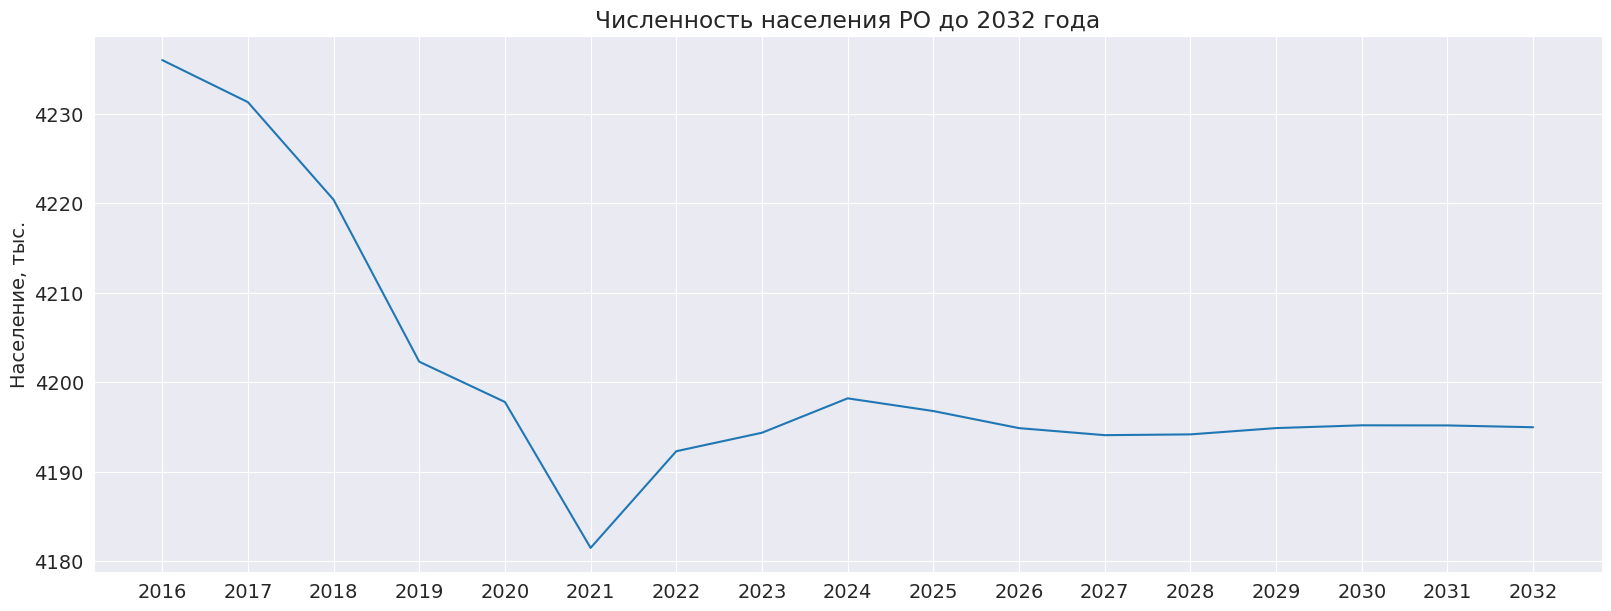

In [ ]:
fig, ax = plt.subplots(layout='constrained')
ax.set_title('Численность населения РО до 2032 года')
ax.set_ylabel('Население, тыс.')
ax.plot(['2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032'], values['Total population'])

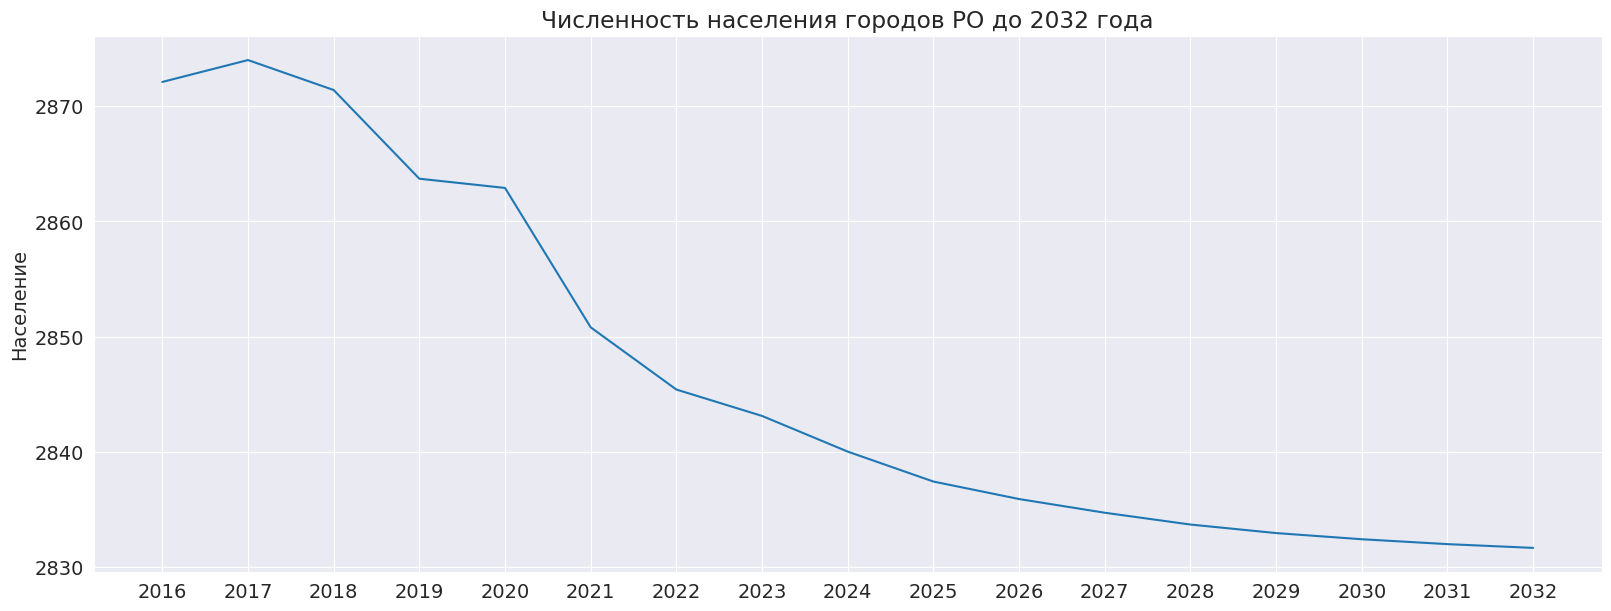

In [ ]:
fig, ax = plt.subplots(layout='constrained')
ax.set_title('Численность населения городов РО до 2032 года')
ax.set_ylabel('Население')
ax.plot(['2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032'], values['City population'])

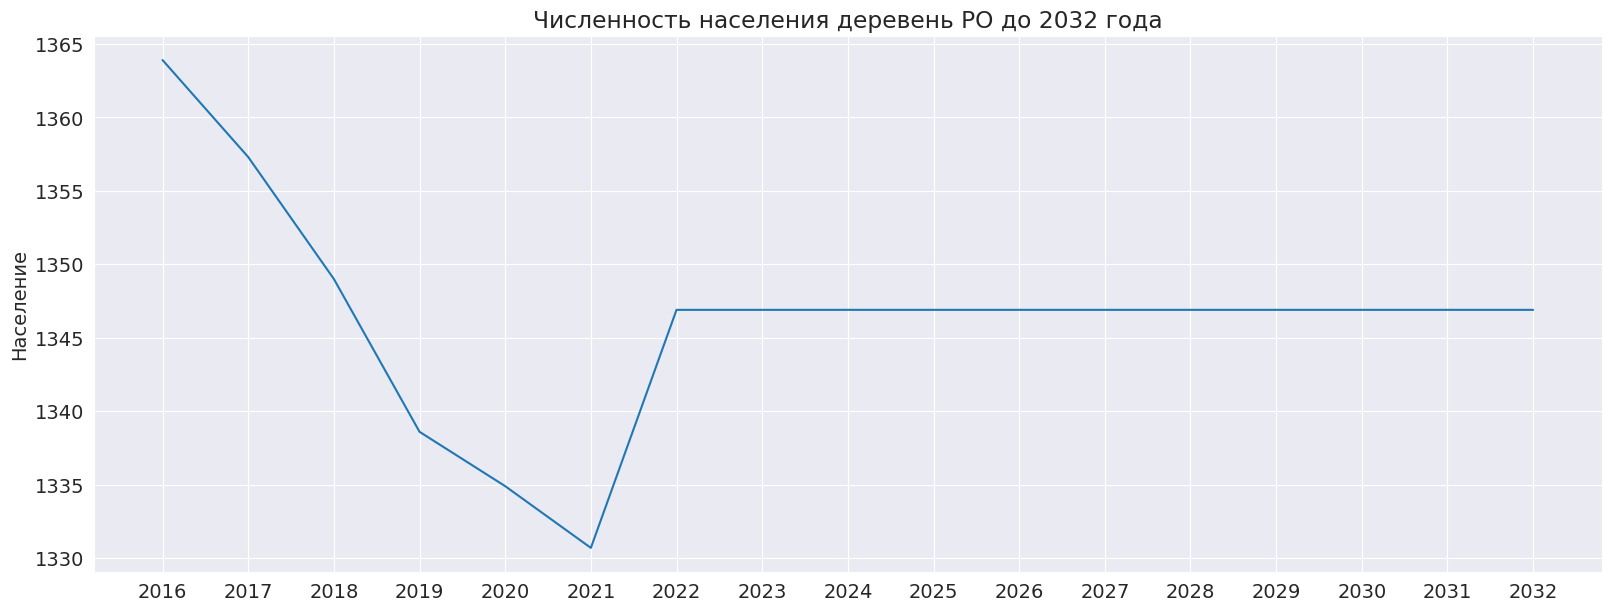

In [ ]:
fig, ax = plt.subplots(layout='constrained')
ax.set_title('Численность населения деревень РО до 2032 года')
ax.set_ylabel('Население')
ax.plot(['2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032'], values['Village population'])

In [ ]:
# Посмотрим на полученные модели
print(len(trained_models))
print(len(list(trained_models.values())[0]))

3
331


In [ ]:
# Сохраним каждую из них
for model_name in trained_models.keys():
  with open(f'models/trained_{model_name}_models.pkl', 'wb') as f:
    pickle.dump(trained_models[model_name], f)

In [ ]:
# Убедимся что их можно загрузить
with open('models/trained_arima_models.pkl', 'rb') as f:
  tms = pickle.load(f)
  print(len(tms))

331
